In [1]:
%load_ext autoreload
%autoreload 2
from utils import plot_utils
from utils import custom_functions as cuf

import os
import sys
# sys.path.append("../") # go to parent 
from OpenEphys_Analysis.utils.custom_functions import update_progress
# from fcutils.plot.distributions import plot_kde
import glob
import ntpath
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import math
import seaborn as sns
import pandas as pd
import warnings
from itertools import chain
import random
from datetime import datetime
from scipy import stats
from matplotlib.cm import ScalarMappable
from matplotlib.patches import FancyBboxPatch



warnings.filterwarnings('ignore')

In [2]:
import scipy
print(scipy.__version__)

1.4.1


In [2]:
# Task
BpodProtocol = '/Two_Alternative_Choice/'
# Behavioural data
GeneralDirectory = cuf.get_data_folder() + '/Behavioural_Data/Bpod_data/'

output_directory_name =  'DAoptostimulation_Mar22'

outputDir = GeneralDirectory + output_directory_name + '_Analysis/'
if not os.path.isdir(outputDir):
    print('I dont find this')
else:
    # Read the dataframe
    AnimalsDF = pd.read_pickle(outputDir + output_directory_name + '_dataframe.pkl')
    print('Dataframe read')

Dataframe read


In [3]:
# Correct a session that was not properly marked
AnimalsDF.loc[AnimalsDF.SessionID=='DAopto-06 Mar30 15:28', 'Stimulation'] = 'Right'

In [4]:
# Correct data for April first, where fibers where connected the other way around
AnimalsDF.loc[AnimalsDF.SessionID=='DAopto-01 Apr01 13:54', 'Stimulation'] = 'Right'
AnimalsDF.loc[AnimalsDF.SessionID=='DAopto-02 Apr01 13:54', 'Stimulation'] = 'Left'
AnimalsDF.loc[AnimalsDF.SessionID=='DAopto-03 Apr01 14:50', 'Stimulation'] = 'Right'
AnimalsDF.loc[AnimalsDF.SessionID=='DAopto-04 Apr01 14:40', 'Stimulation'] = 'Right'
AnimalsDF.loc[AnimalsDF.SessionID=='DAopto-05 Apr01 15:27', 'Stimulation'] = 'Right'
AnimalsDF.loc[AnimalsDF.SessionID=='DAopto-06 Apr01 15:35', 'Stimulation'] = 'Right'
AnimalsDF.loc[AnimalsDF.SessionID=='DAopto-07 Apr01 16:12', 'Stimulation'] = 'Right'
AnimalsDF.loc[AnimalsDF.SessionID=='DAopto-08 Apr01 16:17', 'Stimulation'] = 'Left'
AnimalsDF.loc[AnimalsDF.SessionID=='DAopto-09 Apr01 16:49', 'Stimulation'] = 'Right'
AnimalsDF.loc[AnimalsDF.SessionID=='DAopto-10 Apr01 16:54', 'Stimulation'] = 'Right'

## Analysis of 'Just One Port' stimulation

In [6]:
# In this version of the task, mice receive 150 initial trials without stimulation, and then ports in one port are
# always stimulated

In [7]:
#Subselect dataset
pulledData = AnimalsDF[AnimalsDF.Stimulation != "NoStimulation"]

In [8]:
# Select only sessions with more than 350 trials
tr_below = 325
tisessdf = pulledData.groupby('SessionID').max().reset_index()[['SessionID', 'TrialIndex']]
sess_to_remove = list(tisessdf[tisessdf.TrialIndex < tr_below]['SessionID'])
pulledData = pulledData[~pulledData.SessionID.isin(sess_to_remove)]

In [9]:
#Select only sessions over date (less stimulation, physiological parameters?)
str_format = '%b%d %H:%M'
limit_date = 'Mar29 00:01'
session_times = [datetime.strptime(x, str_format) for x in pulledData.SessionTime.unique()]
date_mask = [x > datetime.strptime(limit_date, str_format) for x in session_times]
selected_dates = [x.strftime(str_format) for x in np.array(session_times)[date_mask]]
pulledData = pulledData[pulledData.SessionTime.isin(selected_dates)]

In [10]:
# Select cases when stimulation was only on one side and 150 trials were w/o opto
jop_mask = []
fot_mask = []
for x in pulledData.FullGUI:
    if 'JustOnePort' in x and x['JustOnePort'] == 1:
        jop_mask.append(True)
    else:
        jop_mask.append(False)
        
    if 'FreeOptoIniTrials' in x and x['FreeOptoIniTrials'] == 150:
        fot_mask.append(True)
    else:
        fot_mask.append(False)

pulledData = pulledData.iloc[np.logical_and(jop_mask, fot_mask)]

In [11]:
# Select how to group trial numbers to compare
ini_trials = 150 # initial trials without stimulation
ao_trials = 225 # trials without stimulation, after some sampling

Progress: [####################] 100.0%


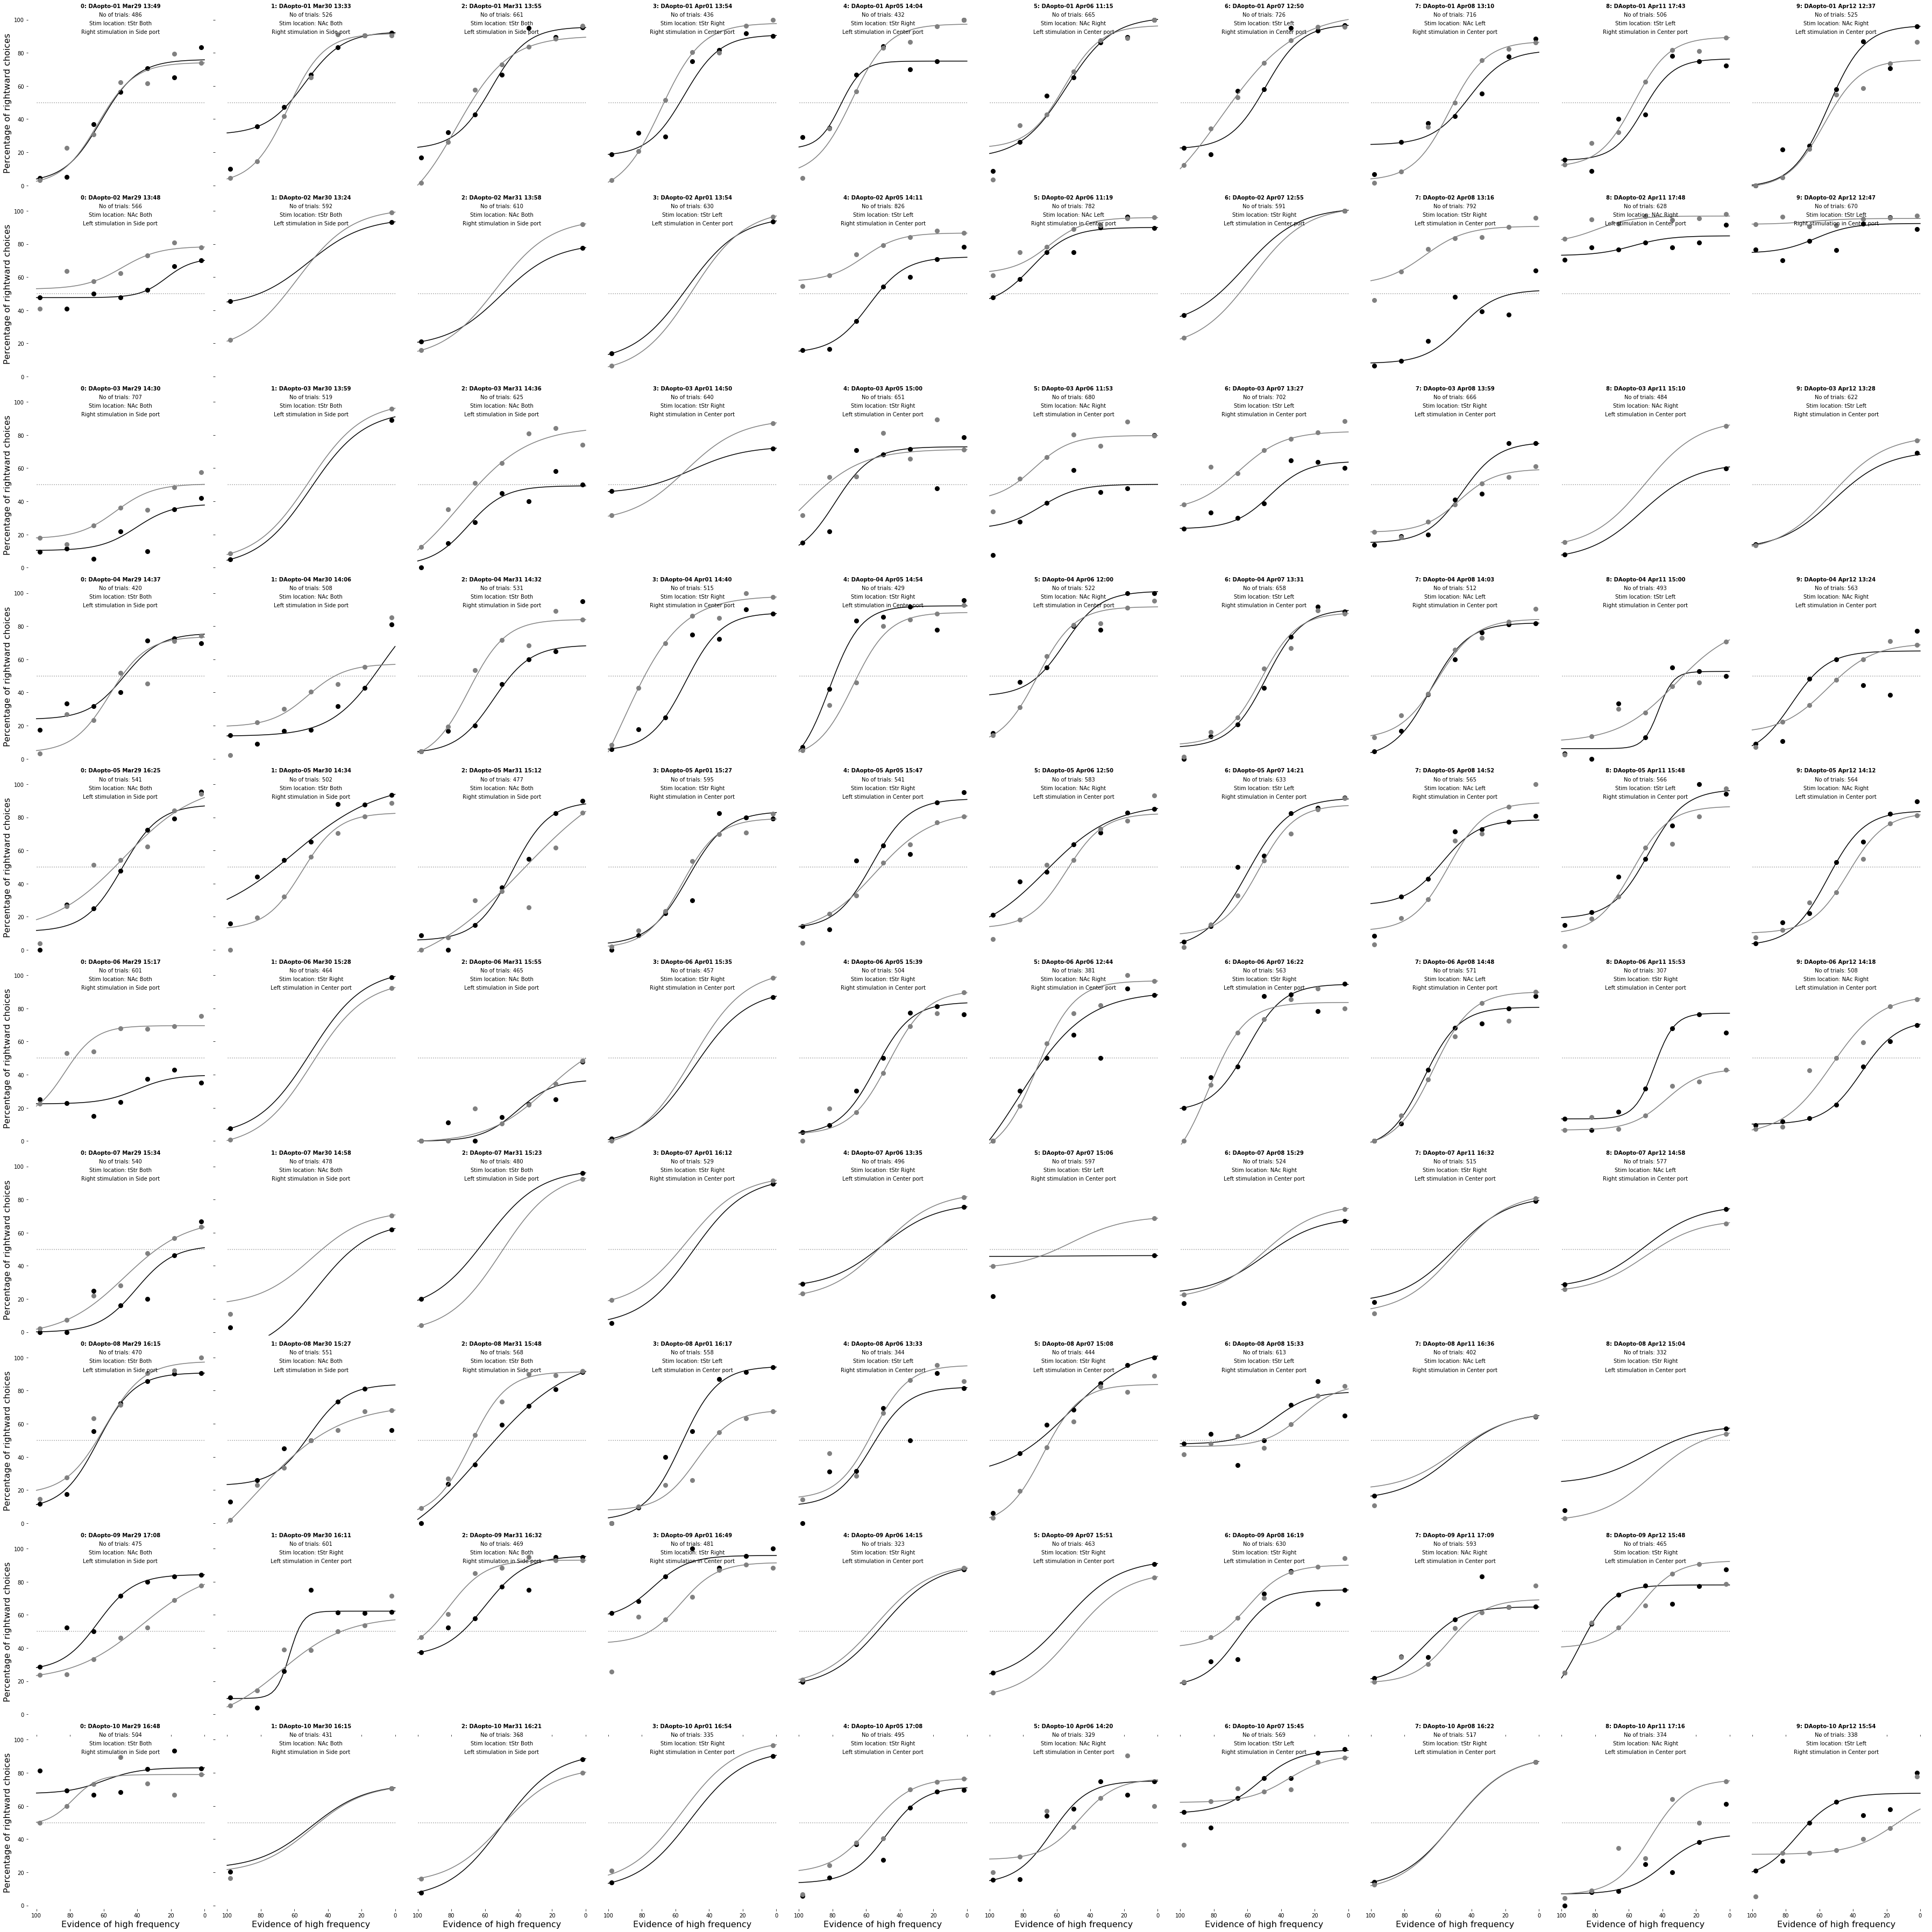

In [11]:
# Plot the data with the error bars for the random sampling, and the custom fitting
# regenerate GUI labels
BRS = ['tStr', 'NAc']
PS = ['Left', 'Right']
PI = ['Center', 'Side']

CondList = [(pulledData['TrialIndex'] < ini_trials),
            (pulledData['TrialIndex'] > ao_trials)]
ColorList = ['black', 'grey']
LabelList = ['Normal', 'After opto']

n_cols = pulledData.groupby('AnimalID')['SessionID'].nunique().max()

fig, axs = plt.subplots(len(pd.unique(pulledData['AnimalID'])), n_cols,
                        figsize=(5 * n_cols, 5 * len(pd.unique(pulledData['AnimalID']))),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

for ax in axs.ravel(): ax.axis('off')

for an_counter, animal in enumerate(pd.unique(pulledData['AnimalID'])):
    animal_df = pulledData[pulledData['AnimalID'] == animal]
    
    for counter, session in enumerate(pd.unique(animal_df['SessionID'])):
        session_df = pulledData[pulledData['SessionID'] == session]
        
        ax = axs[an_counter, counter]        
        ax.hlines(50, 0, 100, linestyles='dotted', alpha=0.4)

        # overlay fits
        for i, condition in enumerate(CondList):
            plot_utils.plot_regression(df=session_df[condition], ax=ax,
                                       color=ColorList[i], label=LabelList[i], plot_points=True)
        ax.set_ylabel('Percentage of rightward choices' , fontsize=16)    
        ax.set_xlabel('Evidence of high frequency', fontsize=16)
        
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
                   
        ax.set_ylim(-2., 102.)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
        ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
                       labelleft='on', labelbottom='on')
        # get rid of the frame
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        plt.tight_layout()
        
        ax.invert_xaxis()
        
        ax.get_legend().remove()
        ax.text(.5,1.05, str(counter) + ': ' + (session), \
                          horizontalalignment='center', fontweight='bold', transform=ax.transAxes)
        ax.text(.5,1, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                          horizontalalignment='center', transform=ax.transAxes)
        # Fiber location
        fl = BRS[int(session_df.iloc[0].FullGUI['FiberLocation']) - 1]
        # Side
        side = session_df.Stimulation.unique()[0]
        ax.text(.5,.95, 'Stim location: ' + fl + ' ' + side , \
                          horizontalalignment='center', transform=ax.transAxes)
        # Port stimulated
        port = PI[int(session_df.iloc[0].FullGUI['OptoState']) - 1]
        portside = PS[int(session_df.iloc[0].FullGUI['JOPSide']) - 1]
        ax.text(.5,.9, portside + ' stimulation in ' + port + ' port' , \
                          horizontalalignment='center', transform=ax.transAxes)

    update_progress(an_counter / len(pd.unique(pulledData['AnimalID'])))
    
update_progress(1)
plt.savefig(outputDir + output_directory_name + '_individual_opto_sessions_just-one-port-150.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [12]:
# calculate a general value for each session (general bias)
# group the data

In [12]:
def get_general_right_bias(df_one, df_two):
    'returns the general bias to the right, between df_one and df_two'
    # mean choices for each data frame for each difficulty
    tdone = np.array(df_one['TrialHighPerc'])
    ssone = np.array(df_one['FirstPoke'])
    _, perf_one = cuf.get_choices(ssone, tdone)
    tdtwo = np.array(df_two['TrialHighPerc'])
    sstwo = np.array(df_two['FirstPoke'])
    _, perf_two = cuf.get_choices(sstwo, tdtwo)
    
    return np.mean(perf_one) - np.mean(perf_two)

def get_random_biases(df, n_times, it, aot):
    # create array
    rblist = np.zeros(n_times)
    for i in range(n_times):
        # shuffle TrialIndexes
        df.TrialIndex = df.TrialIndex.sample(frac=1).values
        # calculate bias
        rblist[i] = get_general_right_bias(df[df.TrialIndex < it], df[df.TrialIndex > aot])
    return rblist

In [13]:
# Generate another dataset for every session
# TODO: include here random biases, and global means and std
n_times = 1000

cols = ['AnimalID', 'SessionID', 'Ntrials', 'Protocol', 'Stim', 'FiberSide',\
        'FiberArea', 'StimSide', 'StimPort', 'Contralateral', 'InitialBias', 'Bias', 'BiasToStimPort',\
        'RandomBiases', 'RandomBiasMean', 'RandomBiasStd']
data = np.empty([len(pd.unique(pulledData['SessionID'])), len(cols)], dtype=object)

for i, sessionid in enumerate(pd.unique(pulledData['SessionID'])):
    # get dataframe of the session
    session_df = pulledData[pulledData['SessionID'] == sessionid].copy()
    # get animal name
    animalid = session_df.AnimalID.unique()[0]
    # get number of trials
    ntrials = session_df.shape[0]
    # protocol
    protocol = session_df.Protocol.unique()[0]
    # is it a stimulated session?
    stim = session_df.Stimulation.unique()[0] != 'NoStimulation'
    # which fiber was plugged in
    fiberside = session_df.Stimulation.unique()[0]
    # which brain area is this fiber over
    fiberarea = BRS[int(session_df.iloc[0].FullGUI['FiberLocation']) - 1]
    # which one of the side ports, or trial type, was stimulated
    stimside = PS[int(session_df.iloc[0].FullGUI['JOPSide']) - 1]
    # in which one of the ports did stimulation occurred
    stimport = PI[int(session_df.iloc[0].FullGUI['OptoState']) - 1]
    # is the fiber contralateral to the port
    contralateral = True
    if (fiberside == stimside) or fiberside == 'Both':
        contralateral = False
    # what is the initial bias of the mouse in trials before stimulation
    ini_sess = session_df[session_df.TrialIndex < ini_trials].copy()
    initialbias = np.mean(cuf.get_choices(ini_sess['FirstPoke'], ini_sess['TrialHighPerc'])[1])
    # what is the total bias of that session after opto
    bias = get_general_right_bias(session_df[CondList[1]], session_df[CondList[0]])
    # is this bias positive towards the stimulated port?
    if stimside == 'Right':
        biastostimport = bias
    if stimside == 'Left':
        biastostimport = - bias
    # calculate random biases
    randombiases = get_random_biases(session_df, n_times, ini_trials, ao_trials)
    # random mean
    randombiasmean = np.mean(randombiases)
    # random std
    randombiasstd = np.std(randombiases)
    
    # fill
    data[i] = [animalid, sessionid, ntrials, protocol, stim, fiberside, fiberarea,\
               stimside, stimport, contralateral, initialbias, bias, biastostimport,\
               randombiases, randombiasmean, randombiasstd]
    
    update_progress(i / len(pd.unique(pulledData['SessionID'])))

# create dataframe
opto_df = pd.DataFrame(data, columns=cols)
update_progress(1)

NameError: name 'BRS' is not defined

In [15]:
# save this dataframe as it takes long to calculate
opto_df.to_pickle(outputDir + output_directory_name + '_random-opto_dataframe.pkl')

In [14]:
# read it
opto_df = pd.read_pickle(outputDir + output_directory_name + '_random-opto_dataframe.pkl')

In [15]:
# plot all sessions for individual animals TODO

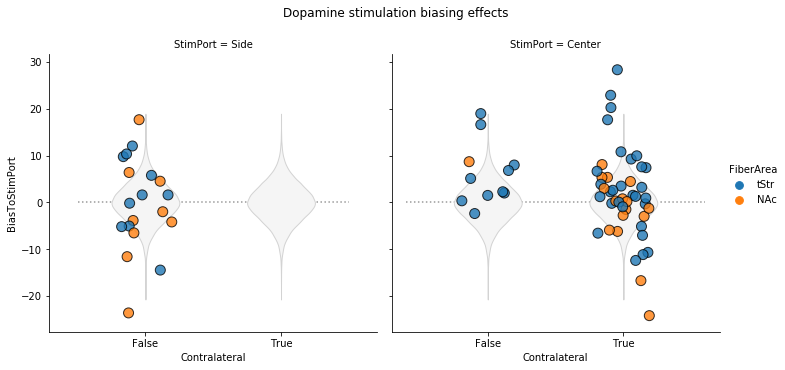

In [15]:
# plot general biases

#### conditions 
extreme_ini_bias = 100/3
conditions = opto_df.Protocol.isin(['Aud_Psycho', 'Auditory'])
conditions = np.logical_and(conditions, extreme_ini_bias < opto_df.InitialBias)
conditions = np.logical_and(conditions, (100 - extreme_ini_bias) > opto_df.InitialBias)
# TODO: filter by good performance as well (?)

rel = sns.catplot(data=opto_df[conditions], x='Contralateral', y='BiasToStimPort', hue='FiberArea', col='StimPort',
                  alpha=.8, size=5, marker='o', s=10, linewidth=1, edgecolor="k", jitter=.2)

#move overall title up
rel.fig.subplots_adjust(top=.85)
rel.fig.suptitle('Dopamine stimulation biasing effects')
# add the distribution of the random biases
randbiases = np.array([item for sublist in opto_df[conditions].RandomBiases.values for item in sublist])
axs = rel.fig.axes
for ax in axs:
    ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], linestyles='dotted', alpha=0.4, zorder=-2)
    for pos in ax.get_xticks():
        parts = ax.violinplot(randbiases, positions=[pos], showmeans=False, showmedians=False, showextrema=False)
        for pc in parts['bodies']:
            pc.set_alpha(1)
            pc.set_zorder(-1)
            pc.set_facecolor('whitesmoke')
            pc.set_edgecolor('lightgrey')
plt.savefig(outputDir + output_directory_name + '_just-one-port-150_biases.pdf', transparent=True, bbox_inches='tight')
plt.show(rel)

In [16]:
# THIS IS DONE ON THE TOTAL OF SESSIONS AND NOT ON THE SPECIFIC ONES FOR EACH CONDITION
# calculate the significance between experiments and the random biases
data = []
cols = ['FiberArea', 'Contralateral', 'StimPort', 'pval']
for fiber_area in opto_df[cols[0]].unique():
    for contra in opto_df[cols[1]].unique():
        for stim_port in opto_df[cols[2]].unique():
            mask = np.logical_and(opto_df.StimPort == stim_port, opto_df.Contralateral == contra)
            mask = np.logical_and(mask, opto_df.FiberArea == fiber_area)
            dist_to_compare = opto_df.BiasToStimPort[np.logical_and(mask, conditions)].values
            kt = stats.kruskal(dist_to_compare, randbiases)
#             print(', '.join([fiber_area, str(contra), stim_port]) + ':\t\tpvalue: ' + str(kt.pvalue) )
            data.append([fiber_area, contra, stim_port, kt.pvalue])
pvals_df = pd.DataFrame(data, columns=cols)
pvals_df

,FiberArea,Contralateral,StimPort,pval
0,tStr,False,Side,0.322629
1,tStr,False,Center,0.003429
2,tStr,True,Side,NaN
3,tStr,True,Center,0.015215
4,NAc,False,Side,0.249350
5,NAc,False,Center,0.096892
6,NAc,True,Side,NaN
7,NAc,True,Center,0.592543


In [17]:
opto_df[np.logical_and(conditions, opto_df.FiberArea=='tStr')].sort_values(by=['BiasToStimPort'])

,AnimalID,SessionID,Ntrials,Protocol,Stim,FiberSide,FiberArea,StimSide,StimPort,Contralateral,InitialBias,Bias,BiasToStimPort,RandomBiases,RandomBiasMean,RandomBiasStd
41,DAopto-05,DAopto-05 Mar30 14:34,502,Aud_Psycho,True,Both,tStr,Right,Side,False,64.001,-14.4526,-14.4526,"[3.721360339007397, 7.5325968672286265, 3.8178...",-0.0235826,4.14693
96,DAopto-10,DAopto-10 Apr12 15:54,338,Aud_Psycho,True,Left,tStr,Right,Center,True,50.4166,-12.3882,-12.3882,"[8.661967202339873, 4.452387837726192, 4.30164...",-0.25073,5.80599
84,DAopto-09,DAopto-09 Apr08 16:19,630,Aud_Psycho,True,Right,tStr,Left,Center,True,55.046,11.1464,-11.1464,"[-2.0625311402446584, -0.7647039320985769, 7.6...",-0.128602,4.09804
24,DAopto-03,DAopto-03 Apr05 15:00,651,Aud_Psycho,True,Right,tStr,Left,Center,True,53.4028,10.6723,-10.6723,"[-7.209630156092963, -5.196498972105296, 0.354...",0.143374,4.34846
48,DAopto-05,DAopto-05 Apr11 15:48,566,Aud_Psycho,True,Left,tStr,Right,Center,True,57.9548,-7.03408,-7.03408,"[3.530481087479437, 1.8368146640234926, -1.366...",0.204737,3.71237
91,DAopto-10,DAopto-10 Apr05 17:08,495,Aud_Psycho,True,Right,tStr,Left,Center,True,40.6262,6.56671,-6.56671,"[-0.6297149888113722, 3.931888121686235, -4.94...",0.0884529,4.44429
69,DAopto-08,DAopto-08 Mar29 16:15,470,Aud_Psycho,True,Both,tStr,Left,Side,False,60.4924,5.17366,-5.17366,"[-4.061749236027644, 0.40288355887432203, 3.77...",0.211644,3.99727
46,DAopto-05,DAopto-05 Apr07 14:21,633,Aud_Psycho,True,Left,tStr,Right,Center,True,55.1116,-5.12169,-5.12169,"[-4.85511950130396, -4.3085636801171034, 0.606...",-0.0952722,3.63329
21,DAopto-03,DAopto-03 Mar30 13:59,519,Auditory,True,Both,tStr,Left,Side,False,47.0783,5.04712,-5.04712,"[-0.8037419685247258, -4.71569492786206, 1.927...",-0.0989825,2.75431
54,DAopto-06,DAopto-06 Apr05 15:39,504,Aud_Psycho,True,Right,tStr,Right,Center,False,47.1736,-2.37795,-2.37795,"[0.07073735772622314, 1.415764790764797, -6.53...",-0.0811557,4.09888


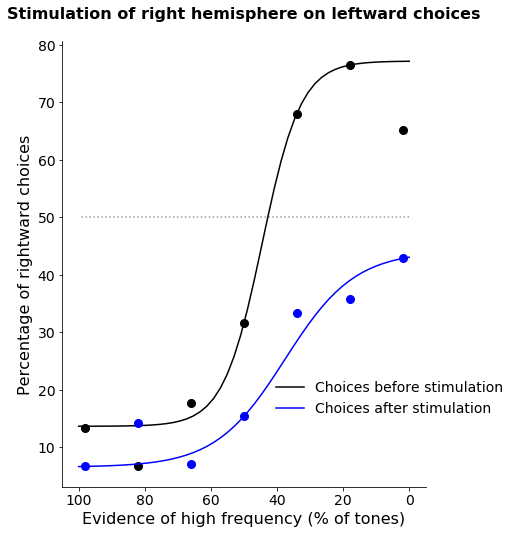

In [18]:
# get a nice example of a shift
example_session = 'DAopto-06 Apr11 15:53'

CondList = [(pulledData['TrialIndex'] < ini_trials),
            (pulledData['TrialIndex'] > ao_trials)]
ColorList = ['black', 'blue']
LabelList = ['Choices before stimulation', 'Choices after stimulation']

fig, ax = plt.subplots(1, 1,
                        figsize=(7, 7),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

# ax.axis('off')

session_df = pulledData[pulledData['SessionID'] == example_session]
        
ax.hlines(50, 0, 100, linestyles='dotted', alpha=0.4)


# overlay fits
for i, condition in enumerate(CondList):
    plot_utils.plot_regression(df=session_df[condition], ax=ax,
                               color=ColorList[i], label=LabelList[i], plot_points=True)
#axs[counter].set_ylabel('')
#axs[counter].set_xlabel('')
# ax.axis('on')
# remove some ticks
# ax.tick_params(top=False, bottom='on', left='on', right=False)

ax.set_ylabel('Percentage of rightward choices' , fontsize=16)
    
ax.set_xlabel('Evidence of high frequency (% of tones)', fontsize=16)

# ax.set_ylim(-2., 102.)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          bbox_to_anchor=(.9, .25), loc='upper center', borderaxespad=0., ncol=1, frameon=False, fontsize=14)
# ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
#                labelleft='on', labelbottom='on')
# get rid of the frame
# for spine in ax.spines.values():
#     spine.set_visible(False)

plt.tight_layout()

ax.invert_xaxis()

#         ax.get_legend().remove()
ax.text(.5,1.05, 'Stimulation of right hemisphere on leftward choices', \
                  horizontalalignment='center', fontweight='bold', transform=ax.transAxes, fontsize=16)
# ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
#                   horizontalalignment='center', transform=ax.transAxes)
# ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
#                   horizontalalignment='center', transform=ax.transAxes, fontsize=16)
# ax.text(.5,.95, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
#                   horizontalalignment='center', transform=ax.transAxes, fontsize=16)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(outputDir + output_directory_name + '_just-one-port-150_example_session.pdf', transparent=True, bbox_inches='tight')
plt.show()


In [19]:
# save copy
opto_df_copy = opto_df.copy()

In [84]:
opto_df = opto_df_copy.copy()

In [85]:
# Subselect the dataframe based on some conditions

#### conditions 
extreme_ini_bias = 100/3
conditions = opto_df.Protocol.isin(['Aud_Psycho', 'Auditory'])
conditions = np.logical_and(conditions, extreme_ini_bias < opto_df.InitialBias)
conditions = np.logical_and(conditions, (100 - extreme_ini_bias) > opto_df.InitialBias)
conditions = np.logical_and(conditions, opto_df.Contralateral==True)
conditions = np.logical_and(conditions, opto_df.StimPort=='Center')

opto_df_sel = opto_df[conditions].copy()

In [86]:
# We cannot repeat points. If several sessions exist for one mouse on the same conditions of hemisphere
# and stimulated side, combine them (average results), or select one of them based on performance or time
# when it was done


# Find indexes of repeated cases
same_columns = ['AnimalID', 'FiberSide', 'FiberArea', 'StimSide', 'StimPort']
equal_indexes = []

for index in opto_df_sel.index:
    data = opto_df_sel.loc[index][same_columns].values
    i_list = []
    for i in opto_df_sel.index:
        if np.array_equal(data, opto_df_sel.loc[i][same_columns].values):
            i_list.append(i)
    if len(i_list) > 1:
        if i_list not in equal_indexes:
            equal_indexes.append(i_list)

In [87]:
# Combine those cases
for case in equal_indexes:   
    sub_df = opto_df_sel.loc[case].copy()
    # create new instance to add to the dataframe, initiating it in the first index of the set
    new_element = sub_df.iloc[0].copy()
    # change relevant values
    new_element.SessionID = 'merge'
    new_element.Ntrials = np.mean(sub_df.Ntrials.values)
    new_element.Protocol = 'merge'
    new_element.InitialBias = np.nan
    new_element.Bias = np.nan
    new_element.BiasToStimPort = np.mean(sub_df.BiasToStimPort.values)
    new_element.RandomBiases = np.concatenate(sub_df.RandomBiases.values)
    new_element.RandomBiasMean = np.mean(new_element.RandomBiases)
    new_element.RandomBiasStd = np.std(new_element.RandomBiases)
    # remove old indexes
    opto_df_sel.drop(case, inplace=True)
    # add new row
    opto_df_sel = opto_df_sel.append(new_element)
opto_df_sel.sort_index(inplace=True)

In [88]:
opto_df_sel

,AnimalID,SessionID,Ntrials,Protocol,Stim,FiberSide,FiberArea,StimSide,StimPort,Contralateral,InitialBias,Bias,BiasToStimPort,RandomBiases,RandomBiasMean,RandomBiasStd
4,DAopto-01,DAopto-01 Apr05 14:04,432,Aud_Psycho,True,Right,tStr,Left,Center,True,65.6355,0.1986,-0.1986,"[6.278312899430915, 1.542348214062045, -6.4136...",0.172011,4.14757
5,DAopto-01,merge,595,merge,True,Right,NAc,Left,Center,True,NaN,NaN,4.19253,"[4.892206503269854, -2.0465879082918264, 3.731...",-0.0258136,3.88599
6,DAopto-01,merge,616,merge,True,Left,tStr,Right,Center,True,NaN,NaN,4.46765,"[-10.840394982945, 6.854700325943178, -0.85646...",-0.121544,3.94872
7,DAopto-01,DAopto-01 Apr08 13:10,716,Aud_Psycho,True,Left,NAc,Right,Center,True,47.6736,0.769684,0.769684,"[-5.285920751273352, 5.607665265363956, 3.1423...",0.0426013,3.71993
14,DAopto-02,DAopto-02 Apr05 14:11,826,Aud_Psycho,True,Left,tStr,Right,Center,True,47.0072,28.327,28.327,"[-1.0122799202860335, -0.6307673364066204, -11...",-0.221699,4.00658
24,DAopto-03,merge,658.5,merge,True,Right,tStr,Left,Center,True,NaN,NaN,-4.2024,"[-7.209630156092963, -5.196498972105296, 0.354...",0.165901,4.47038
25,DAopto-03,merge,582,merge,True,Right,NAc,Left,Center,True,NaN,NaN,-20.4431,"[1.9079939753381225, 0.4629012921360598, -2.76...",0.0420767,4.21031
26,DAopto-03,merge,662,merge,True,Left,tStr,Right,Center,True,NaN,NaN,13.1868,"[4.596101393750111, -2.5737091157972287, -3.72...",0.0485386,4.17741
36,DAopto-04,DAopto-04 Apr07 13:31,658,Aud_Psycho,True,Left,tStr,Right,Center,True,47.3667,1.28523,1.28523,"[6.5782830463370985, -4.933987171236716, -0.50...",0.110791,3.75879
37,DAopto-04,DAopto-04 Apr08 14:03,512,Aud_Psycho,True,Left,NAc,Right,Center,True,51.2663,4.4634,4.4634,"[-2.1421694163995326, 2.7281450885310505, -5.7...",-0.0809903,4.32807


In [89]:
# remove NAc DAopto-03 as the fibers are not correctly placed DV
idx_to_remove = opto_df_sel[np.logical_and(opto_df_sel.AnimalID=='DAopto-03',
                           opto_df_sel.FiberArea=='NAc')].index

# remove tStr DAopto-05 L as the fiber is a bit anterior
idx_to_remove_two = opto_df_sel[np.logical_and(np.logical_and(opto_df_sel.AnimalID=='DAopto-05',
                                                              opto_df_sel.FiberArea=='tStr'),
                                               opto_df_sel.FiberSide=='Left')].index

opto_df_sel.drop(idx_to_remove, inplace=True)
opto_df_sel.drop(idx_to_remove_two, inplace=True)

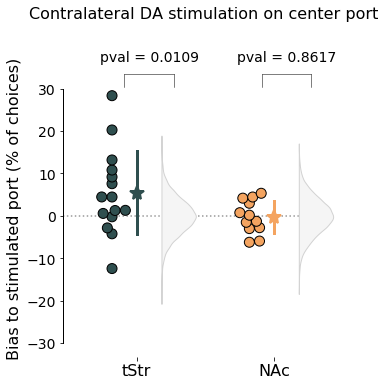

In [90]:
# Focus only on the contralateral stimulation in the center

hor = ['tStr', 'NAc']
# make a palette
colors=['darkslategray', 'sandybrown']

# spread of things
spread = .18

# plot
rel = sns.catplot(data=opto_df_sel, x='FiberArea', y='BiasToStimPort', hue='FiberArea',
                  alpha=1, size=5, marker='o', s=10, linewidth=1, edgecolor="k",# jitter=.15,
                  hue_order=hor,
                  kind='swarm',
                  height=15, aspect=8/8,
                  palette=sns.color_palette(colors))


# add the distribution of the random biases, and mean and std
axs = rel.fig.axes

orig_y_lim = axs[0].get_ylim()[1]

#move overall title up
rel.fig.subplots_adjust(top=.9)
rel.fig.suptitle('Contralateral DA stimulation on center port', y=1.05, fontsize=16)
for ax in axs:
    ax.set_ylabel('Bias to stimulated port (% of choices)', fontsize=16)
    ax.set_xlabel('')
    ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], linestyles='dotted', alpha=0.4, zorder=-2)
    for i, pos in enumerate(ax.get_xticks()):
        facond = opto_df_sel.FiberArea==hor[i]
        randbiases = np.array([item for sublist in opto_df_sel[facond].RandomBiases.values for item in sublist])
        parts = ax.violinplot(randbiases, positions=[pos+2*spread], showmeans=False, showmedians=False, showextrema=False)
        for pc in parts['bodies']:
            pc.set_alpha(1)
            pc.set_zorder(-2)
            pc.set_facecolor('whitesmoke')
            pc.set_edgecolor('lightgrey')
            # do only half
            # get the center
            m = np.mean(pc.get_paths()[0].vertices[:, 0])
            # modify the paths to not go further left than the center
            pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], m, np.inf)
        
        # mean and std
        dist_to_compare = opto_df_sel[facond].BiasToStimPort.values
        xm = np.mean(dist_to_compare)
        xstd = np.std(dist_to_compare)
        ax.plot([i+spread, i+spread], [xm - xstd, xm + xstd], '-', color=colors[i], zorder=50, linewidth=3,
                alpha=1)
        ax.plot(i+spread, xm, '*', markerfacecolor=colors[i], zorder=50,
                markeredgewidth=2, markersize=15, markeredgecolor=colors[i])

        # add the significance
        pval = stats.kruskal(dist_to_compare, randbiases).pvalue
        ax.text(x=i+1.5*spread, y=1.2 * orig_y_lim, s='pval = {:.6}'.format(str(pval)),
                horizontalalignment='center', fontsize=14)
        ax.plot([i+spread*.5, i+2.5*spread], [orig_y_lim*1.1, orig_y_lim*1.1], color='k', linewidth=.5)
        ax.plot([i+spread*.5, i+.5*spread], [orig_y_lim, orig_y_lim*1.1], color='k', linewidth=.5)
        ax.plot([i+spread*2.5, i+2.5*spread], [orig_y_lim, orig_y_lim*1.1], color='k', linewidth=.5)
        
    
#     ymin, ymax = ax.get_yaxis().get_view_interval()
    

    ax.set_xlim([-2*spread, 1+5*spread])
    ax.set_xticks([spread, 1+spread])
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    
    # keep only y axis and floating x ticks
    ax.set_frame_on(False)
    xmin, xmax = ax.get_xaxis().get_view_interval()
    ax.plot((xmin, xmin), (-30, 30), color='black', linewidth=1)
    
# # highlight the example session
# xm = opto_df[opto_df.SessionID == example_session].BiasToStimPort.values
# ax.plot(0, xm, 'o', color='k', zorder=50, markersize=10)
        
plt.savefig(outputDir + output_directory_name + '_just-one-port-150_biases_simple_center-contralateral.pdf', transparent=True, bbox_inches='tight')
plt.show(rel)

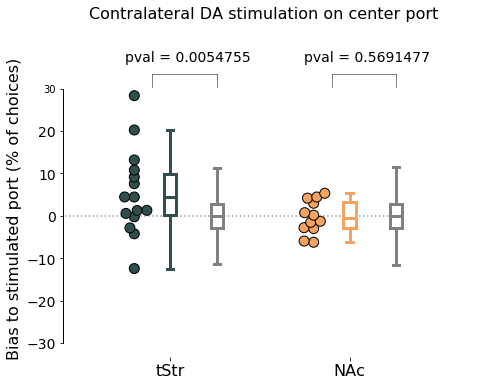

In [112]:
# Do a version with boxplots

hor = ['tStr', 'NAc']
# make a palette
colors=['darkslategray', 'sandybrown']

# spread of things
spread = .2
randspread = 2.3*spread

# plot
rel = sns.catplot(data=opto_df_sel, x='FiberArea', y='BiasToStimPort', hue='FiberArea',
                  alpha=1, size=5, marker='o', s=10, linewidth=1, edgecolor="k",# jitter=.15,
                  hue_order=hor,
                  kind='swarm',
                  height=15, aspect=8/6,
                  palette=sns.color_palette(colors))


# add the distribution of the random biases, and mean and std
axs = rel.fig.axes

orig_y_lim = axs[0].get_ylim()[1]

#move overall title up
rel.fig.subplots_adjust(top=.9)
rel.fig.suptitle('Contralateral DA stimulation on center port', y=1.05, fontsize=16)
for ax in axs:
    ax.set_ylabel('Bias to stimulated port (% of choices)', fontsize=16)
    ax.set_xlabel('')
    ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], linestyles='dotted', alpha=0.4, zorder=-2)
    for i, pos in enumerate(ax.get_xticks()):
        facond = opto_df_sel.FiberArea==hor[i]
        randbiases = np.array([item for sublist in opto_df_sel[facond].RandomBiases.values for item in sublist])
        bp = ax.boxplot(randbiases, positions=[pos+randspread], widths=0.07, 
                           patch_artist=True, showfliers=False)
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color='gray', linewidth=3)
        for patch in bp['boxes']:
            patch.set(facecolor='white')

        
        # mean and std
        dist_to_compare = opto_df_sel[facond].BiasToStimPort.values
        bp = ax.boxplot(dist_to_compare, positions=[pos+spread], widths=0.07, 
                           patch_artist=True, showfliers=False)
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color=colors[i], linewidth=3)
        for patch in bp['boxes']:
            patch.set(facecolor='white')

        # add the significance
#         pval = stats.kruskal(dist_to_compare, randbiases).pvalue
        pval = stats.ranksums(dist_to_compare, randbiases, alternative='greater').pvalue
        ax.text(x=i+1.5*spread, y=1.2 * orig_y_lim, s='pval = {:.9}'.format(str(pval)),
                horizontalalignment='center', fontsize=14)
        ax.plot([i+spread*.5, i+randspread], [orig_y_lim*1.1, orig_y_lim*1.1], color='k', linewidth=.5)
        ax.plot([i+spread*.5, i+.5*spread], [orig_y_lim, orig_y_lim*1.1], color='k', linewidth=.5)
        ax.plot([i+randspread, i+randspread], [orig_y_lim, orig_y_lim*1.1], color='k', linewidth=.5)
        
    
#     ymin, ymax = ax.get_yaxis().get_view_interval()
    

    ax.set_xlim([-2*spread, 1+5*spread])
    ax.set_xticks([spread, 1+spread])
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    
    # keep only y axis and floating x ticks
    ax.set_frame_on(False)
    xmin, xmax = ax.get_xaxis().get_view_interval()
    ax.plot((xmin, xmin), (-30, 30), color='black', linewidth=1)
    
# # highlight the example session
# xm = opto_df[opto_df.SessionID == example_session].BiasToStimPort.values
# ax.plot(0, xm, 'o', color='k', zorder=50, markersize=10)
        
plt.savefig(outputDir + output_directory_name + '_just-one-port-150_biases_simple_center-contralateral_boxplots.pdf', transparent=True, bbox_inches='tight')
plt.show(rel)

In [92]:
# TODO: test for significance that is biases to the stimulated port. One-way anova


facond = opto_df_sel.FiberArea=='tStr'
randbiases = np.array([item for sublist in opto_df_sel[facond].RandomBiases.values for item in sublist])
dist_to_compare = opto_df_sel[facond].BiasToStimPort.values
# stats.ttest_ind(dist_to_compare, randbiases, alternative='greater').pvalue

stats.ranksums(dist_to_compare, randbiases, alternative='greater')

RanksumsResult(statistic=2.544256012673317, pvalue=0.005475539400654341)

In [93]:
opto_df_sel.groupby(['AnimalID', 'FiberSide','FiberArea']).groups

{('DAopto-01', 'Left', 'NAc'): Int64Index([7], dtype='int64'),
 ('DAopto-01', 'Left', 'tStr'): Int64Index([6], dtype='int64'),
 ('DAopto-01', 'Right', 'NAc'): Int64Index([5], dtype='int64'),
 ('DAopto-01', 'Right', 'tStr'): Int64Index([4], dtype='int64'),
 ('DAopto-02', 'Left', 'tStr'): Int64Index([14], dtype='int64'),
 ('DAopto-03', 'Left', 'tStr'): Int64Index([26], dtype='int64'),
 ('DAopto-03', 'Right', 'tStr'): Int64Index([24], dtype='int64'),
 ('DAopto-04', 'Left', 'NAc'): Int64Index([37], dtype='int64'),
 ('DAopto-04', 'Left', 'tStr'): Int64Index([36], dtype='int64'),
 ('DAopto-04', 'Right', 'NAc'): Int64Index([39], dtype='int64'),
 ('DAopto-05', 'Left', 'NAc'): Int64Index([47], dtype='int64'),
 ('DAopto-05', 'Right', 'NAc'): Int64Index([45], dtype='int64'),
 ('DAopto-05', 'Right', 'tStr'): Int64Index([44], dtype='int64'),
 ('DAopto-06', 'Left', 'NAc'): Int64Index([57], dtype='int64'),
 ('DAopto-06', 'Right', 'tStr'): Int64Index([51], dtype='int64'),
 ('DAopto-07', 'Left', 'NAc')

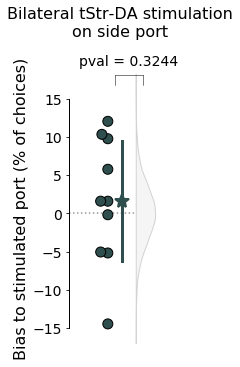

In [94]:
# Show that it is not aversive THERE ARE NO DUPLICATES IN THIS DATASET SO ALL IS GOOD
# Focus only on the contralateral stimulation in the center

hor = ['tStr', 'NAc']
# make a palette
colors=['darkslategray']

# spread of things
spread = .18

#### conditions 
extreme_ini_bias = 100/3
conditions = opto_df.Protocol.isin(['Aud_Psycho', 'Auditory'])
conditions = np.logical_and(conditions, extreme_ini_bias < opto_df.InitialBias)
conditions = np.logical_and(conditions, (100 - extreme_ini_bias) > opto_df.InitialBias)
conditions = np.logical_and(conditions, opto_df.Contralateral==False)
conditions = np.logical_and(conditions, opto_df.StimPort=='Side')
conditions = np.logical_and(conditions, opto_df.FiberArea=='tStr')

# plot
rel = sns.catplot(data=opto_df[conditions], x='FiberArea', y='BiasToStimPort', hue='FiberArea',
                  alpha=1, size=5, marker='o', s=10, linewidth=1, edgecolor="k",# jitter=.15,
                  hue_order=hor,
                  kind='swarm',
                  height=15, aspect=4/8, palette=sns.color_palette(colors))

#move overall title up
rel.fig.subplots_adjust(top=.9)
rel.fig.suptitle('Bilateral tStr-DA stimulation\non side port', y=1.05, fontsize=16)
# add the distribution of the random biases, and mean and std
axs = rel.fig.axes
orig_y_lim = axs[0].get_ylim()[1]
for ax in axs:
    ax.set_ylabel('Bias to stimulated port (% of choices)', fontsize=16)
    ax.set_xlabel('')
    ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], linestyles='dotted', alpha=0.4, zorder=-2)
    for i, pos in enumerate(ax.get_xticks()):
        facond = np.logical_and(conditions, opto_df.FiberArea==hor[i])
        randbiases = np.array([item for sublist in opto_df[facond].RandomBiases.values for item in sublist])
        parts = ax.violinplot(randbiases, positions=[pos+2*spread], showmeans=False, showmedians=False, showextrema=False)
        for pc in parts['bodies']:
            pc.set_alpha(1)
            pc.set_zorder(-2)
            pc.set_facecolor('whitesmoke')
            pc.set_edgecolor('lightgrey')
            # do only half
            # get the center
            m = np.mean(pc.get_paths()[0].vertices[:, 0])
            # modify the paths to not go further left than the center
            pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], m, np.inf)
        
        # mean and std
        dist_to_compare = opto_df[facond].BiasToStimPort.values
        xm = np.mean(dist_to_compare)
        xstd = np.std(dist_to_compare)
        ax.plot([i+spread, i+spread], [xm - xstd, xm + xstd], '-', color=colors[i], zorder=50, linewidth=3,
                alpha=1)
        ax.plot(i+spread, xm, '*', markerfacecolor=colors[i], zorder=50,
                markeredgewidth=2, markersize=15, markeredgecolor=colors[i])
        
        

        # add the significance
        pval = stats.kruskal(dist_to_compare, randbiases).pvalue
        ax.text(x=i+1.5*spread, y=1.45 * orig_y_lim, s='pval = {:.6}'.format(str(pval)),
                horizontalalignment='center', fontsize=14)
        ax.plot([i+spread*.5, i+2.5*spread], [orig_y_lim*1.35, orig_y_lim*1.35], color='k', linewidth=.5)
        ax.plot([i+spread*.5, i+.5*spread], [orig_y_lim*1.25, orig_y_lim*1.35], color='k', linewidth=.5)
        ax.plot([i+spread*2.5, i+2.5*spread], [orig_y_lim*1.25, orig_y_lim*1.35], color='k', linewidth=.5)
    
#     ax.set_xlim([-2*spread, 1+5*spread])
    ax.set_xticks([spread, 1+spread])
    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    
    # keep only y axis and floating x ticks
    ax.set_frame_on(False)
    xmin, xmax = ax.get_xaxis().get_view_interval()
    ax.plot((xmin, xmin), (-15, 15), color='black', linewidth=1)
    ax.get_xaxis().set_visible(False)

plt.savefig(outputDir + output_directory_name + '_just-one-port-150_biases_simple_side-bilateral.pdf', transparent=True, bbox_inches='tight')
plt.show(rel)

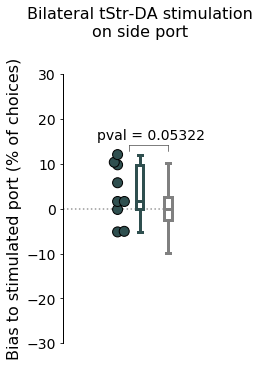

In [113]:
# BOXPLOT VERSION

hor = ['tStr', 'NAc']
# make a palette
colors=['darkslategray']

# spread of things
spread = .2
randspread = 2.3*spread

#### conditions 
extreme_ini_bias = 100/3
conditions = opto_df.Protocol.isin(['Aud_Psycho', 'Auditory'])
conditions = np.logical_and(conditions, extreme_ini_bias < opto_df.InitialBias)
conditions = np.logical_and(conditions, (100 - extreme_ini_bias) > opto_df.InitialBias)
conditions = np.logical_and(conditions, opto_df.Contralateral==False)
conditions = np.logical_and(conditions, opto_df.StimPort=='Side')
conditions = np.logical_and(conditions, opto_df.FiberArea=='tStr')
#remove daopto-05
conditions = np.logical_and(conditions, opto_df.AnimalID!='DAopto-05')

# plot
rel = sns.catplot(data=opto_df[conditions], x='FiberArea', y='BiasToStimPort', hue='FiberArea',
                  alpha=1, size=5, marker='o', s=10, linewidth=1, edgecolor="k",# jitter=.15,
                  hue_order=hor,
                  kind='swarm',
                  height=15, aspect=4/6, palette=sns.color_palette(colors))

#move overall title up
rel.fig.subplots_adjust(top=.9)
rel.fig.suptitle('Bilateral tStr-DA stimulation\non side port', y=1.05, fontsize=16)
# add the distribution of the random biases, and mean and std
axs = rel.fig.axes
orig_y_lim = axs[0].get_ylim()[1]
for ax in axs:
    ax.set_ylabel('Bias to stimulated port (% of choices)', fontsize=16)
    ax.set_xlabel('')
    ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], linestyles='dotted', alpha=0.4, zorder=-2)
    for i, pos in enumerate(ax.get_xticks()):
        facond = np.logical_and(conditions, opto_df.FiberArea==hor[i])
        randbiases = np.array([item for sublist in opto_df[facond].RandomBiases.values for item in sublist])
        bp = ax.boxplot(randbiases, positions=[pos+randspread], widths=0.07, 
                           patch_artist=True, showfliers=False)
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color='gray', linewidth=3)
        for patch in bp['boxes']:
            patch.set(facecolor='white')
        
        # mean and std
        dist_to_compare = opto_df[facond].BiasToStimPort.values
        bp = ax.boxplot(dist_to_compare, positions=[pos+spread], widths=0.07, 
                           patch_artist=True, showfliers=False)
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color=colors[i], linewidth=3)
        for patch in bp['boxes']:
            patch.set(facecolor='white')

        # add the significance
#         pval = stats.kruskal(dist_to_compare, randbiases).pvalue
        pval = stats.ranksums(dist_to_compare, randbiases, alternative='greater').pvalue
        ax.text(x=i+1.5*spread, y=1.2 * orig_y_lim, s='pval = {:.7}'.format(str(pval)),
                horizontalalignment='center', fontsize=14)
        ax.plot([i+spread*.5, i+randspread], [orig_y_lim*1.1, orig_y_lim*1.1], color='k', linewidth=.5)
        ax.plot([i+spread*.5, i+.5*spread], [orig_y_lim, orig_y_lim*1.1], color='k', linewidth=.5)
        ax.plot([i+randspread, i+randspread], [orig_y_lim, orig_y_lim*1.1], color='k', linewidth=.5)
    
#     ax.set_xlim([-2*spread, 1+5*spread])
    ax.set_xticks([spread, 1+spread])
    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    
    # keep only y axis and floating x ticks
    ax.set_frame_on(False)
    xmin, xmax = ax.get_xaxis().get_view_interval()
    ax.plot((xmin, xmin), (-30, 30), color='black', linewidth=1)
    ax.get_xaxis().set_visible(False)

plt.savefig(outputDir + output_directory_name + '_just-one-port-150_biases_simple_side-bilateral_boxplot.pdf', transparent=True, bbox_inches='tight')
plt.show(rel)

In [82]:
opto_df[conditions]

,AnimalID,SessionID,Ntrials,Protocol,Stim,FiberSide,FiberArea,StimSide,StimPort,Contralateral,InitialBias,Bias,BiasToStimPort,RandomBiases,RandomBiasMean,RandomBiasStd
0,DAopto-01,DAopto-01 Mar29 13:49,486,Aud_Psycho,True,Both,tStr,Right,Side,False,46.013,1.60279,1.60279,"[-2.175802421490175, 0.6891377509755188, 4.353...",0.295121,4.40676
2,DAopto-01,DAopto-01 Mar31 13:55,661,Aud_Psycho,True,Both,tStr,Left,Side,False,62.5575,-1.5998,1.5998,"[-2.719128389920293, -0.9653225556157423, 0.84...",-0.10878,3.54264
21,DAopto-03,DAopto-03 Mar30 13:59,519,Auditory,True,Both,tStr,Left,Side,False,47.0783,5.04712,-5.04712,"[-0.8037419685247258, -4.71569492786206, 1.927...",-0.0989825,2.75431
30,DAopto-04,DAopto-04 Mar29 14:37,420,Aud_Psycho,True,Both,tStr,Left,Side,False,48.0377,-5.77862,5.77862,"[1.5063779591090523, -8.06486475335322, 3.9535...",0.0744471,5.1369
32,DAopto-04,DAopto-04 Mar31 14:32,531,Aud_Psycho,True,Both,tStr,Right,Side,False,43.7026,12.0499,12.0499,"[-4.943857774916786, -1.7973006177340594, 2.87...",0.0890121,4.16095
62,DAopto-07,DAopto-07 Mar31 15:23,480,Auditory,True,Both,tStr,Left,Side,False,57.9167,-9.77378,9.77378,"[2.2693902083215036, 6.870696882963479, -0.048...",-0.0361077,2.77242
69,DAopto-08,DAopto-08 Mar29 16:15,470,Aud_Psycho,True,Both,tStr,Left,Side,False,60.4924,5.17366,-5.17366,"[-4.061749236027644, 0.40288355887432203, 3.77...",0.211644,3.99727
71,DAopto-08,DAopto-08 Mar31 15:48,568,Aud_Psycho,True,Both,tStr,Right,Side,False,51.575,10.3483,10.3483,"[-3.7325539263925407, 0.3124922625377735, -4.5...",0.0701451,3.88663
89,DAopto-10,DAopto-10 Mar31 16:21,368,Auditory,True,Both,tStr,Left,Side,False,47.9539,0.171131,-0.171131,"[-5.094960784584963, -10.707646849076589, 0.42...",0.0181727,4.14107


In [162]:
# test combining all psychometrics
#### conditions 
extreme_ini_bias = 100/3
conditions = opto_df.Protocol.isin(['Aud_Psycho'])
conditions = np.logical_and(conditions, extreme_ini_bias < opto_df.InitialBias)
conditions = np.logical_and(conditions, (100 - extreme_ini_bias) > opto_df.InitialBias)
conditions = np.logical_and(conditions, opto_df.Contralateral==True)
conditions = np.logical_and(conditions, opto_df.StimPort=='Center')
conditions = np.logical_and(conditions, opto_df.FiberArea=='tStr')
len(all_sessions)
opto_df_sel = opto_df[conditions].copy()

In [163]:
opto_df_sel

,AnimalID,SessionID,Ntrials,Protocol,Stim,FiberSide,FiberArea,StimSide,StimPort,Contralateral,InitialBias,Bias,BiasToStimPort,RandomBiases,RandomBiasMean,RandomBiasStd
4,DAopto-01,DAopto-01 Apr05 14:04,432,Aud_Psycho,True,Right,tStr,Left,Center,True,65.6355,0.1986,-0.1986,"[6.278312899430915, 1.542348214062045, -6.4136...",0.172011,4.14757
6,DAopto-01,DAopto-01 Apr07 12:50,726,Aud_Psycho,True,Left,tStr,Right,Center,True,63.0978,1.51743,1.51743,"[-10.840394982945, 6.854700325943178, -0.85646...",-0.00177546,3.69407
8,DAopto-01,DAopto-01 Apr11 17:43,506,Aud_Psycho,True,Left,tStr,Right,Center,True,47.4886,7.41786,7.41786,"[4.642703743770369, -3.685290018065338, -2.963...",-0.241312,4.18448
14,DAopto-02,DAopto-02 Apr05 14:11,826,Aud_Psycho,True,Left,tStr,Right,Center,True,47.0072,28.327,28.327,"[-1.0122799202860335, -0.6307673364066204, -11...",-0.221699,4.00658
24,DAopto-03,DAopto-03 Apr05 15:00,651,Aud_Psycho,True,Right,tStr,Left,Center,True,53.4028,10.6723,-10.6723,"[-7.209630156092963, -5.196498972105296, 0.354...",0.143374,4.34846
26,DAopto-03,DAopto-03 Apr07 13:27,702,Aud_Psycho,True,Left,tStr,Right,Center,True,44.8706,22.8832,22.8832,"[4.596101393750111, -2.5737091157972287, -3.72...",0.145627,4.50718
27,DAopto-03,DAopto-03 Apr08 13:59,666,Aud_Psycho,True,Right,tStr,Left,Center,True,41.2088,-2.2675,2.2675,"[8.051592391104116, 3.4747014781795116, -0.221...",0.188428,4.58895
36,DAopto-04,DAopto-04 Apr07 13:31,658,Aud_Psycho,True,Left,tStr,Right,Center,True,47.3667,1.28523,1.28523,"[6.5782830463370985, -4.933987171236716, -0.50...",0.110791,3.75879
44,DAopto-05,DAopto-05 Apr05 15:47,541,Aud_Psycho,True,Right,tStr,Left,Center,True,55.0541,-7.59752,7.59752,"[3.9030834871750244, 2.299029228569424, -1.569...",-0.161989,4.18773
46,DAopto-05,DAopto-05 Apr07 14:21,633,Aud_Psycho,True,Left,tStr,Right,Center,True,55.1116,-5.12169,-5.12169,"[-4.85511950130396, -4.3085636801171034, 0.606...",-0.0952722,3.63329


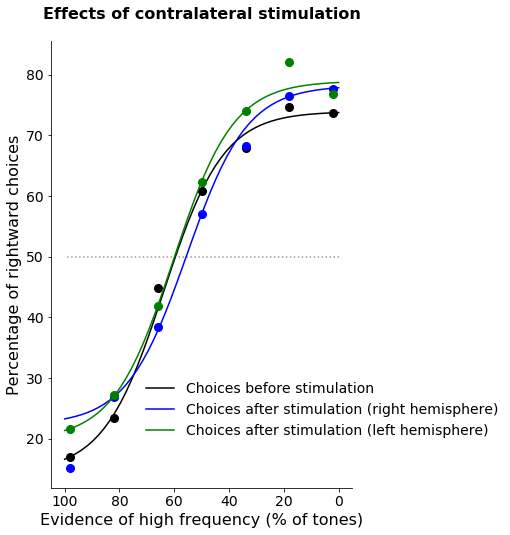

In [46]:
all_sessions = opto_df_sel.SessionID.values
right_sessions = opto_df_sel[opto_df_sel.FiberSide=='Right'].SessionID.values
left_sessions = opto_df_sel[opto_df_sel.FiberSide=='Left'].SessionID.values

all_df = pulledData[pulledData['SessionID'].isin(all_sessions)]
all_df = all_df[all_df['TrialIndex'] < ini_trials]

right_df = pulledData[pulledData['SessionID'].isin(right_sessions)]
right_df = right_df[right_df['TrialIndex'] > ao_trials]

left_df = pulledData[pulledData['SessionID'].isin(left_sessions)]
left_df = left_df[left_df['TrialIndex'] > ao_trials]

session_list = [all_df, right_df, left_df]
ColorList = ['black', 'blue', 'green']
LabelList = ['Choices before stimulation',
             'Choices after stimulation (right hemisphere)',
             'Choices after stimulation (left hemisphere)']



fig, ax = plt.subplots(1, 1,
                        figsize=(7, 7),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

# ax.axis('off')


        
ax.hlines(50, 0, 100, linestyles='dotted', alpha=0.4)


# overlay fits
for i, df in enumerate(session_list):
    plot_utils.plot_regression(df=df, ax=ax,
                               color=ColorList[i], label=LabelList[i], plot_points=True)
#axs[counter].set_ylabel('')
#axs[counter].set_xlabel('')
# ax.axis('on')
# remove some ticks
# ax.tick_params(top=False, bottom='on', left='on', right=False)

ax.set_ylabel('Percentage of rightward choices' , fontsize=16)
    
ax.set_xlabel('Evidence of high frequency (% of tones)', fontsize=16)

# ax.set_ylim(-2., 102.)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          bbox_to_anchor=(.9, .25), loc='upper center', borderaxespad=0., ncol=1, frameon=False, fontsize=14)
# ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
#                labelleft='on', labelbottom='on')
# get rid of the frame
# for spine in ax.spines.values():
#     spine.set_visible(False)

plt.tight_layout()

ax.invert_xaxis()

#         ax.get_legend().remove()
ax.text(.5,1.05, 'Effects of contralateral stimulation', \
                  horizontalalignment='center', fontweight='bold', transform=ax.transAxes, fontsize=16)
# ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
#                   horizontalalignment='center', transform=ax.transAxes)
# ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
#                   horizontalalignment='center', transform=ax.transAxes, fontsize=16)
# ax.text(.5,.95, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
#                   horizontalalignment='center', transform=ax.transAxes, fontsize=16)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(outputDir + output_directory_name + '_just-one-port-150_all_psychometric.pdf', transparent=True, bbox_inches='tight')
plt.show()


In [200]:
len(left_sessions)

14

In [29]:
# include non-stimulated sessions to see if there is something general about correcting bias.
# If so, do not include those sessions 

In [25]:
# tests with Fede's plotting function

def triple_plot(
        x_pos, 
        y, ax, 
        color='k', 
        shift=0.25, 
        zorder=100, 
        scatter_kws=None, 
        kde_kwargs=None,
        box_width=0.5,
        kde_normto=None,
        invert_order = False,
        fill=0.1, 
        pad=0.0,
        spread=0.01,
        horizontal=False,
        show_kde=True,
    ):
    '''
        Given a 1d array of data it plots a scatter of the data (with x_pos as X coords)
        a box plot of the distribution and a KDE of the distribution
    '''
    if invert_order:
        scatter_x = 0
        box_x = - shift
        kde_x = - 2 * shift
        if kde_normto is not None:
            kde_normto = - kde_normto
    else:
        scatter_x = 0
        box_x = shift
        kde_x = 2 * shift
    x = np.random.normal(x_pos, spread, size=len(y))

    # scatter plot
    # data = align_points_to_grid(np.vstack([x, y]).T, fill=fill, pad=pad)
    data = np.vstack([x, y]).T
    scatter_kws = scatter_kws or dict(s=15)
    if horizontal:
        ax.scatter(data[:, 1] + scatter_x, data[:, 0], color=color, **scatter_kws,  lw=0, zorder=zorder+1)
    else:
        ax.scatter(data[:, 0] + scatter_x, data[:, 1], color=color, **scatter_kws,  lw=0, zorder=zorder+1)

    # box plot
    boxes = ax.boxplot(
        y, 
        positions=[x_pos+box_x], 
        zorder=zorder, 
        widths=box_width,
        showcaps=False,
        showfliers=False,
        patch_artist=True,
        boxprops = dict(color='k'),
        whiskerprops = dict(color=[.4, .4, .4], lw=2),
        medianprops = dict(color='blue', lw=4),
        meanprops = dict(color='r', lw=2),
        manage_ticks=False,
        meanline=True,
        vert = not horizontal,
        )

    if not boxes['boxes']:
        raise ValueError('no boxes drawn')

    for box in boxes["boxes"]:
        box.set(facecolor = "k")

    # kde plot
    if show_kde:
        kde_kwargs = kde_kwargs or dict(bw=.25)
        plot_kde(
            ax=ax, 
            data=y, 
            vertical=not horizontal, 
            z=x_pos+kde_x, 
            color=color, 
            kde_kwargs=kde_kwargs, 
            zorder=zorder,
            normto=kde_normto,
        )

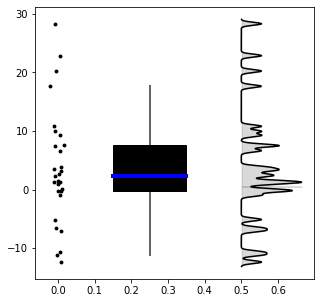

In [31]:
hor = ['tStr', 'NAc']
# TODO make a palette

#### conditions 
extreme_ini_bias = 100/3
conditions = opto_df.Protocol.isin(['Aud_Psycho', 'Auditory'])
conditions = np.logical_and(conditions, extreme_ini_bias < opto_df.InitialBias)
conditions = np.logical_and(conditions, (100 - extreme_ini_bias) > opto_df.InitialBias)
conditions = np.logical_and(conditions, opto_df.Contralateral==True)
conditions = np.logical_and(conditions, opto_df.StimPort=='Center')
conditions = np.logical_and(conditions, opto_df.FiberArea=='tStr')

fig, ax = plt.subplots(1, 1,
                       figsize=(5, 5),
                       facecolor='w',
                       edgecolor='k')
triple_plot(x_pos=0,
            y=opto_df[conditions].BiasToStimPort.values,
            ax=ax,
            box_width=0.2)

## Analysis of stimulation when inmobile

In [96]:
BEFORE_STIM_FRAMES = 27

def calculate_speed(x, y):
    displacement_change_x = np.abs(np.diff(np.array(x)))
    displacement_change_y = np.abs(np.diff(np.array(y)))
    displacement = np.mean(np.array([displacement_change_x, displacement_change_y]), axis=0)
    displacement = np.insert(displacement, 0, 0, 0)
    return displacement

def get_speed_array(df, idxs, window, avg_size, columnname):
    # allocate array
    arr = np.full([len(idxs), window+BEFORE_STIM_FRAMES], np.nan)
    for i, idx in enumerate(idxs):
        sp_vals = df.loc[(idx-BEFORE_STIM_FRAMES):(idx+window-1)][columnname].values
    
        # smooth
        kernel_size = avg_size
        kernel = np.ones(kernel_size) / kernel_size
        arr[i,:] = np.convolve(sp_vals, kernel, mode='same')
    
    return arr

def calculate_moving_frame(arr, thr):
    bool_arr = arr > thr
    # check that animal moves in that trial
    moving_mask = np.any(bool_arr, axis=1)
    # get first indexes
    arr_to_ret = np.argmax(bool_arr, axis=1)
    # trials where animal does not move show as 0s in argmax
    arr_to_ret[~moving_mask] = 200
    
    return arr_to_ret


# from the internet:

from scipy import interpolate

def fill_nan(A):
    '''
    interpolate to fill nan values
    '''
    inds = np.arange(A.shape[0])
    good = np.where(np.isfinite(A))
    f = interpolate.interp1d(inds[good], A[good],bounds_error=False)
    B = np.where(np.isfinite(A),A,f(inds))
    return B


In [97]:
# raw_data_dir = '/home/hernandom/data/Behavioural_Data/rtpp/DA_stimulation_when_inmobile_Apr2022/NAc_control/raw_data'
# raw_data_dir = '/home/hernandom/data/Behavioural_Data/rtpp/DA_stimulation_when_inmobile_Apr2022/None_control/raw_data'
# raw_data_dir = '/home/hernandom/data/Behavioural_Data/rtpp/DA_stimulation_when_inmobile_Apr2022/raw_data'
raw_data_dir = '/home/hernandom/data/Behavioural_Data/rtpp/DA_stimulation_when_inmobile_Apr2022/LightON_control/raw_data'

# create output dir
out_dir = os.path.join(os.path.dirname(raw_data_dir), 'processed_data/')
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
files = glob.glob(raw_data_dir + '/*.csv')

# read and process files
dfs = []
for file in files:
    print('Working with {}'.format(os.path.basename(file)))
    # get the animal name
    an_name = os.path.basename(file).split('_')[5]
    # open file
    df = pd.read_csv(file)
    # add the animal name
    df['animal_id'] = an_name
    # calculate the speed
    df['speed'] = calculate_speed(df.centroid_x.values, df.centroid_y.values)
    # calculate the acceleration
    df['acceleration'] = np.insert(np.abs(np.diff(df.speed.values)), 0, 0, 0)
    # append
    dfs.append(df)

# combine
fdf = pd.concat(dfs, ignore_index=True)

Working with rtpp__stim_when_still_DAopto-10_LightON-R__2022_05_05_11_56_27.csv
Working with rtpp__stim_when_still_DAopto-06_LightON__2022_05_05_10_51_25.csv
Working with rtpp__stim_when_still_DAopto-04_LightON__2022_05_05_10_06_37.csv
Working with rtpp__stim_when_still_DAopto-08_LightON-R__2022_05_09_14_42_20.csv
Working with rtpp__stim_when_still_DAopto-07_LightON-R__2022_05_09_14_04_38.csv
Working with rtpp__stim_when_still_DAopto-03_LightON-L__2022_05_09_13_29_38.csv
Working with rtpp__stim_when_still_DAopto-02_LightON-L__2022_05_09_12_09_29.csv
Working with rtpp__stim_when_still_DAopto-01_LightON-R__2022_05_09_11_29_21.csv
Working with rtpp__stim_when_still_DAopto-05_LightON-R__2022_05_05_15_58_36.csv


In [98]:
# Get the trial events, remove the last one so there is no error if protocol finishes just after
stim_trials_indeces = []
control_trials_indeces = []
for animal in fdf.animal_id.unique():
    animaldf = fdf[fdf.animal_id==animal]
    stidx = animaldf.loc[animaldf.isStimTrial.values == True].index.values[:-1]
    ctidx = animaldf.loc[animaldf.isStimTrial.values == False].index.values[:-1]
    for x in stidx:
        stim_trials_indeces.append(x)
    for x in ctidx:
        control_trials_indeces.append(x)

stim_trials_indeces = np.array(stim_trials_indeces)
control_trials_indeces = np.array(control_trials_indeces)

In [99]:
# get an array that is trials by speed_vector_Xs_after or acceleration
column = 'speed'
s_after = 5
avg_factor = 5
frame_rate = 30
stimulation_array = get_speed_array(fdf, stim_trials_indeces, s_after * frame_rate, avg_factor, column)
control_array = get_speed_array(fdf, control_trials_indeces, s_after * frame_rate, avg_factor, column)

In [100]:
# calculate when they start moving again, and sort based on this
threshold = 5
stim_arr_movini = calculate_moving_frame(stimulation_array, threshold)
control_arr_movini = calculate_moving_frame(control_array, threshold)
# sorting order
stim_sort_order = np.argsort(stim_arr_movini)[::-1]
control_sort_order = np.argsort(control_arr_movini)[::-1]

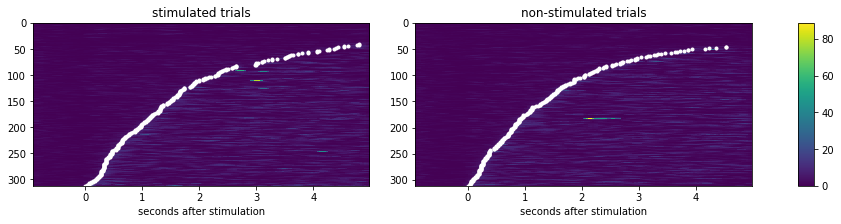

In [101]:
# plot
data = [stimulation_array, control_array]
sort_order = [stim_sort_order, control_sort_order]
movini = [stim_arr_movini, control_arr_movini]
titles = ['stimulated trials', 'non-stimulated trials']

# normalize subplots
cmap = plt.cm.viridis
all_data = np.array(data)
norm = plt.Normalize(np.min([x.min() for x in data]), np.max([x.max() for x in data]))

fig, axs = plt.subplots(1,3, figsize=[14,3], gridspec_kw={"width_ratios":[1, 1, 0.05]})
axs = axs.ravel()
for i, arr in enumerate(data):
    ax = axs[i]
    rgba = cmap(norm(arr[sort_order[i]]))
    ax.imshow(rgba, aspect='auto')
    xlims = ax.get_xlim()
    # add movement initiation times
    movini_vec = movini[i]
    ax.plot(movini_vec[sort_order[i]], range(len(movini_vec)), 'w.')


    #beautify
    ax.set_xlim(xlims)
    xt = [x for x in range(BEFORE_STIM_FRAMES,160,30)]
    ax.set_xticks(xt)
    ax.set_xticklabels([int(x / frame_rate) for x in xt])
    ax.set_xlabel('seconds after stimulation')
    ax.set_title(titles[i])
    
    # add stim window TODO


# Add the colorbar using a ScalarMappable
im = ScalarMappable(norm, cmap)
im.set_array(data)
fig.colorbar(im, cax=axs[2])

plt.savefig(out_dir + 'DAstim_when_inmobile_heatmap_' + column + '_threshold-' + str(threshold) + '.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

In [102]:
# With the light on, sometimes the tracking picks up the top of the fibers
# Fix it
speed_threshold = 20

stimulation_array[stimulation_array > speed_threshold] = np.nan
control_array[control_array > speed_threshold] = np.nan

for i in range(stimulation_array.shape[0]):
    stimulation_array[i,:] = fill_nan(stimulation_array[i,:])

for i in range(control_array.shape[0]):
    control_array[i,:] = fill_nan(control_array[i,:])


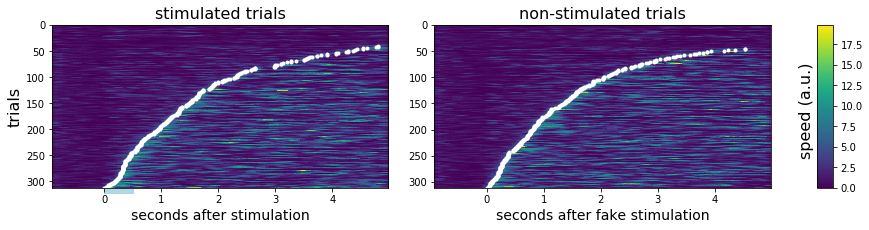

In [103]:
from matplotlib.lines import Line2D


# plot
data = [stimulation_array, control_array]
sort_order = [stim_sort_order, control_sort_order]
movini = [stim_arr_movini, control_arr_movini]
titles = ['stimulated trials', 'non-stimulated trials']

# normalize subplots
cmap = plt.cm.viridis
all_data = np.array(data)
norm = plt.Normalize(np.min([x.min() for x in data]), np.max([x.max() for x in data]))

fig1, axs = plt.subplots(1,3, figsize=[14,3], gridspec_kw={"width_ratios":[1, 1, 0.05]})
axs = axs.ravel()
for i, arr in enumerate(data):
    ax = axs[i]
    rgba = cmap(norm(arr[sort_order[i]]))
    ax.imshow(rgba, aspect='auto')
    xlims = ax.get_xlim()
    
    # add movement initiation times
    movini_vec = movini[i]
    ax.plot(movini_vec[sort_order[i]], range(len(movini_vec)), 'w.')

    #beautify
    ax.set_xlim(xlims)
    xt = [x for x in range(BEFORE_STIM_FRAMES,160,30)]
    ax.set_xticks(xt)
    ax.set_xticklabels([int(x / frame_rate) for x in xt])
    ax.set_title(titles[i], fontsize=16)

axs[0].set_xlabel('seconds after stimulation', fontsize=14)
axs[1].set_xlabel('seconds after fake stimulation', fontsize=14)
axs[0].set_ylabel('trials', fontsize=16)
    
# Add the colorbar using a ScalarMappable
im = ScalarMappable(norm, cmap)
im.set_array(data)
fig1.colorbar(im, cax=axs[2])
axs[2].text(x=-12, y=4, s='speed (a.u.)',
            horizontalalignment='center', fontsize=16, rotation=90)

# add stim window
llw = 10
for i in range(llw):
    line = Line2D([BEFORE_STIM_FRAMES, BEFORE_STIM_FRAMES + .5 * frame_rate],
                  [stimulation_array.shape[0] + i + 1, stimulation_array.shape[0] + i + 1],
                  lw=1, color='lightblue', alpha=1, zorder = -100)
    line.set_clip_on(False)
    axs[0].add_line(line)

plt.savefig(out_dir + 'DAstim_when_inmobile_heatmap_' + column + '_threshold-' + str(threshold) + '_clean.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

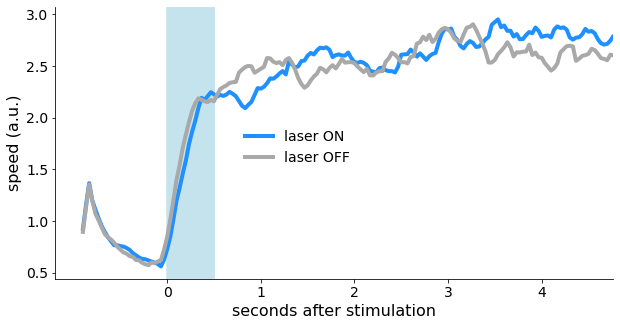

In [104]:
# plot a collapsed heatmap

hues = ['darkgrey', 'dodgerblue']
sns.set_palette(hues)

fig2, ax = plt.subplots(1,1, figsize=[10,5])

ax.plot(np.mean(stimulation_array, axis=0), color=hues[1], linewidth=4, label='laser ON')
ax.plot(np.mean(control_array, axis=0), color=hues[0], linewidth=4, label='laser OFF')

left, bottom, width, height = (BEFORE_STIM_FRAMES, 0, .5 * frame_rate, ax.get_xlim()[1])
rect=FancyBboxPatch((left,bottom),width,height, 
                    #fill=False,
                    alpha=0.7,
                    #color="purple",
                    linewidth=0,
                    facecolor="lightblue",
                    zorder = -3)
ax.add_patch(rect)

ax.set_xticks(xt)
ax.set_xticklabels([int(x / frame_rate) for x in xt])
ax.set_xlabel('seconds after stimulation', fontsize=16)
ax.set_ylabel(column + ' (a.u.)', fontsize=16)
ax.set_xlim([ax.get_xlim()[0], 170])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(frameon=False, fontsize=14, loc=[.33,.4])

plt.savefig(out_dir + 'DAstim_when_inmobile_mean_' + column + '_threshold-' + str(threshold) + '.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

In [105]:
# Plot those trials where the mouse move before Xs timelocked to movement initiation

seconds_after_limit = .5
seconds_after_toplot = 2

stim_mask = stim_arr_movini < (BEFORE_STIM_FRAMES + seconds_after_limit * frame_rate)
control_mask = control_arr_movini < (BEFORE_STIM_FRAMES + seconds_after_limit * frame_rate)

stim_timelocked_array = np.zeros([sum(stim_mask), int(seconds_after_toplot * frame_rate)])
control_timelocked_array = np.zeros([sum(control_mask), int(seconds_after_toplot * frame_rate)])

for i, idx in enumerate(np.where(stim_mask)[0]):
    stim_timelocked_array[i,:] = stimulation_array[idx, stim_arr_movini[idx]:(stim_arr_movini[idx] + int(seconds_after_toplot * frame_rate))]

for i, idx in enumerate(np.where(control_mask)[0]):
    control_timelocked_array[i,:] = control_array[idx, control_arr_movini[idx]:(control_arr_movini[idx] + int(seconds_after_toplot * frame_rate))]

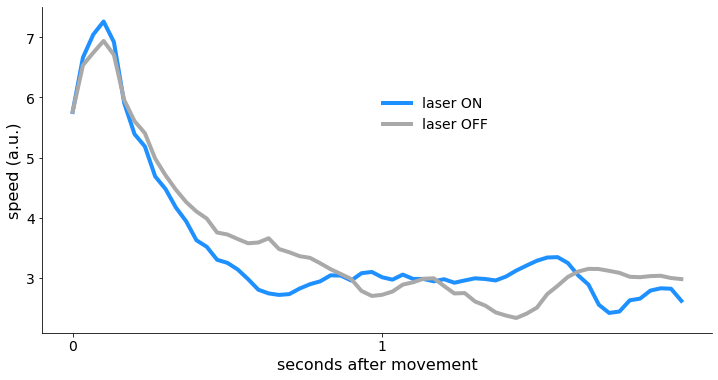

In [106]:
fig4, ax = plt.subplots(1,1, figsize=[12,6])

# plot a collapsed heatmap
ax.plot(np.mean(stim_timelocked_array, axis=0), color=hues[1], linewidth=4, label='laser ON')
ax.plot(np.mean(control_timelocked_array, axis=0), color=hues[0], linewidth=4, label='laser OFF')


xttw = [x for x in range(0,frame_rate * seconds_after_toplot,30)]
ax.set_xticks(xttw)
ax.set_xticklabels([int(x / frame_rate) for x in xttw])
ax.set_xlabel('seconds after movement', fontsize=16)
ax.set_ylabel(column + ' (a.u.)', fontsize=16)
# ax.set_xlim([ax.get_xlim()[0], 170])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=False, fontsize=14, loc=[.5,.6])

plt.savefig(out_dir + 'DAstim_when_inmobile_mean-after-movement_' + column + '_threshold-' + str(threshold) + '.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

In [107]:
# calculate moving averages
stim_mov_avg = [np.mean(x[BEFORE_STIM_FRAMES:]) for x in stimulation_array]
control_mov_avg = [np.mean(x[BEFORE_STIM_FRAMES:]) for x in control_array]

In [108]:
# create a dataframe for plotting distributions
# column_names = ['animal_id', 'isItStimTrial', 'latency_to_move', 'average_movement']
st_df = pd.DataFrame({'animal_id': np.concatenate([fdf.loc[stim_trials_indeces].animal_id.values,
                                                   fdf.loc[control_trials_indeces].animal_id.values]),
                      'stim_trial': np.concatenate([np.repeat(True, len(stim_arr_movini)),
                                                    np.repeat(False, len(control_arr_movini))]),
                      'latency_to_move': np.concatenate([stim_arr_movini, control_arr_movini]),
                      'average_movement': np.concatenate([stim_mov_avg, control_mov_avg]),
                      'trial_with_movement': np.concatenate([stim_arr_movini < 199, control_arr_movini < 199])
                     })

# convert latency to seconds
st_df.latency_to_move = (st_df.latency_to_move - BEFORE_STIM_FRAMES) / frame_rate

In [109]:
# remove the trials in which there is no movement
mov_mask = st_df.latency_to_move < (199 / frame_rate)

In [110]:
# see differences between mice (barplot) for instant speed
instant_speed_seconds = .3
stim_insspd_avg = [np.mean(x[0:int(instant_speed_seconds * frame_rate)]) for x in stim_timelocked_array]
control_insspd_avg = [np.mean(x[0:int(instant_speed_seconds * frame_rate)]) for x in control_timelocked_array]

# create a dataframe for plotting distributions
tl_df = pd.DataFrame({'animal_id': np.concatenate([fdf.loc[stim_trials_indeces].animal_id.values[stim_mask],
                                                   fdf.loc[control_trials_indeces].animal_id.values[control_mask]]),
                      'stim_trial': np.concatenate([np.repeat(True, sum(stim_mask)),
                                                    np.repeat(False, sum(control_mask))]),
                      'instant_speed': np.concatenate([stim_insspd_avg, control_insspd_avg]),
                     })


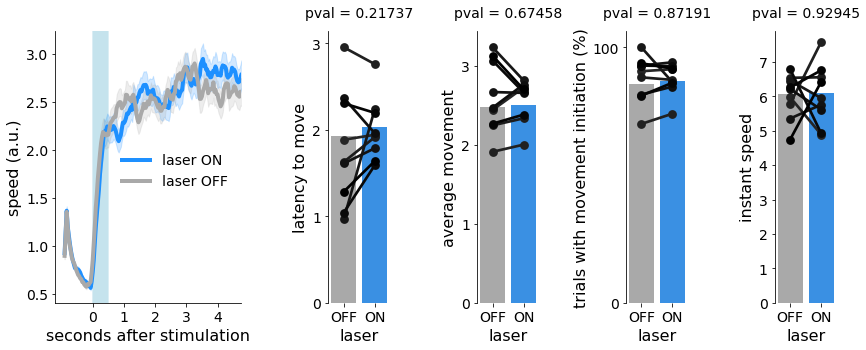

In [115]:
from matplotlib.ticker import MaxNLocator

# Generate barplots together with the collapsed heatmap of speed

hues = ['darkgrey', 'dodgerblue']
sns.set_palette(hues)

fig3, axs = plt.subplots(1, 5, figsize=[14,5], gridspec_kw={'width_ratios': [3, 1, 1, 1, 1]})
axs = axs.ravel()
fig3.subplots_adjust(wspace=1)


# plot a collapsed heatmap
ax = axs[0]
# calculate std
st_std_top = stats.sem(stimulation_array, axis=0) + np.mean(stimulation_array, axis=0)
st_std_bottom = - stats.sem(stimulation_array, axis=0) + np.mean(stimulation_array, axis=0)
con_std_top = stats.sem(control_array, axis=0) + np.mean(control_array, axis=0)
con_std_bottom = - stats.sem(control_array, axis=0) + np.mean(control_array, axis=0)

ax.fill_between(list(range(stimulation_array.shape[1])), st_std_bottom, st_std_top,
                where=st_std_top >= st_std_bottom,
                color=hues[1], alpha=.2, interpolate=False)
ax.fill_between(list(range(control_array.shape[1])), con_std_bottom, con_std_top,
                where=con_std_top >= con_std_bottom,
                color=hues[0], alpha=.2, interpolate=False)
ax.plot(np.mean(stimulation_array, axis=0), color=hues[1], linewidth=4, label='laser ON')
ax.plot(np.mean(control_array, axis=0), color=hues[0], linewidth=4, label='laser OFF')

left, bottom, width, height = (BEFORE_STIM_FRAMES, 0, .5 * frame_rate, ax.get_xlim()[1])
rect=FancyBboxPatch((left,bottom),width,height, 
                    #fill=False,
                    alpha=0.7,
                    #color="purple",
                    linewidth=0,
                    facecolor="lightblue",
                    zorder = -3)
ax.add_patch(rect)

ax.set_xticks(xt)
ax.set_xticklabels([int(x / frame_rate) for x in xt])
ax.set_xlabel('seconds after stimulation', fontsize=16)
ax.set_ylabel(column + ' (a.u.)', fontsize=16)
ax.set_xlim([ax.get_xlim()[0], 170])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(frameon=False, fontsize=14, loc=[.33,.4])

# plot barplots

variables = ['latency_to_move', 'average_movement', 'trial_with_movement']
order_to_plot = [False, True]
sig_ypos = 1.05

for i, variable_to_plot in enumerate(variables):
    ax = axs[i+1]
    sns.barplot(data=st_df[mov_mask], x='stim_trial', y=variable_to_plot, ci=False,
                order=order_to_plot, hue_order=order_to_plot, ax=ax, zorder=-40)
    sns.pointplot(data=st_df[mov_mask], x='stim_trial', y=variable_to_plot, hue='animal_id',
                  color='black', ci=None,
                  order=order_to_plot,
                  ax=ax)
    
    ax.set_ylabel(' '.join(variable_to_plot.split('_')), fontsize=16)
    
    # do stats and add them
    dffst = st_df.groupby(['stim_trial', 'animal_id']).mean().reset_index()
    tt = stats.ttest_rel(dffst[dffst.stim_trial==True][variable_to_plot],
                         dffst[dffst.stim_trial==False][variable_to_plot])

    ax.text(x=.5, y=ax.get_ylim()[1]*sig_ypos, s='pval = {:.7}'.format(str(tt.pvalue)),
                    horizontalalignment='center', fontsize=14)   

# instant speed
ax = axs[4]
sns.barplot(data=tl_df, x='stim_trial', y='instant_speed', ci=False,
            order=order_to_plot, hue_order=order_to_plot, ax=ax, zorder=-40)
sns.pointplot(data=tl_df, x='stim_trial', y='instant_speed', hue='animal_id',
              color='black', ci=None,
              order=order_to_plot,
              ax=ax)

ax.set_ylabel('instant speed', fontsize=16)
ax.set_ylim(0,7.9)
# do stats and add them
dffst = tl_df.groupby(['stim_trial', 'animal_id']).mean().reset_index()
tt = stats.ttest_rel(dffst[dffst.stim_trial==True]['instant_speed'],
                     dffst[dffst.stim_trial==False]['instant_speed'])

ax.text(x=.5, y=ax.get_ylim()[1]*sig_ypos, s='pval = {:.7}'.format(str(tt.pvalue)),
                horizontalalignment='center', fontsize=14)



axs[3].set_ylabel('trials with movement initiation (%)')
axs[3].set_yticklabels(['0', '100'])



# beautify
for ax in axs[1:]:
    ax.get_legend().remove()
    ax.set_xticklabels(['OFF', 'ON'])
    ax.set_xlabel('laser', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))


    
    
    
plt.savefig(out_dir + 'DAstim_when_inmobile_significance_' + column + '_threshold-' + str(threshold) + '.pdf',
            transparent=True, bbox_inches='tight')

plt.show()

In [191]:
def move_axes(ax, fig, subplot_spec=111):
    #   """Move an Axes object from a figure to a new pyplot managed Figure in
    #   the specified subplot."""

    # get a reference to the old figure context so we can release it
    old_fig = ax.figure

    # remove the Axes from it's original Figure context
    ax.remove()

    # set the pointer from the Axes to the new figure
    ax.figure = fig

    # add the Axes to the registry of axes for the figure
    fig.axes.append(ax)
    # twice, I don't know why...
    fig.add_axes(ax)

    # then to actually show the Axes in the new figure we have to make
    # a subplot with the positions etc for the Axes to go, so make a
    # subplot which will have a dummy Axes
    dummy_ax = fig.add_subplot(subplot_spec)

    # then copy the relevant data from the dummy to the ax
    ax.set_position(dummy_ax.get_position())

    # then remove the dummy
    dummy_ax.remove()

    # close the figure the original axis was bound to
    plt.close(old_fig)

In [198]:
fig_grouped = plt.figure(figsize=[5,10])
move_axes(fig3.axes[0], fig_grouped, 121)
move_axes(fig3.axes[0], fig_grouped, subplot_spec=122)
move_axes(fig5.axes[0], fig_grouped, subplot_spec=123)
plt.tight_layout()

IndexError: list index out of range

<Figure size 360x720 with 0 Axes>

In [71]:
tl_df[tl_df.animal_id=='DAopto-08']

,animal_id,stim_trial,instant_speed


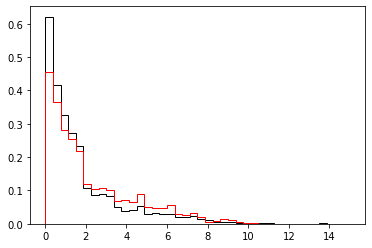

In [373]:
# distributions of values over the first miliseconds
plt.hist([stimulation_array[:, BEFORE_STIM_FRAMES:45], control_array[:, 25:45]], bins=40, color=['r', 'k'],
         normed=True, cumulative=False, histtype='step')
plt.show()

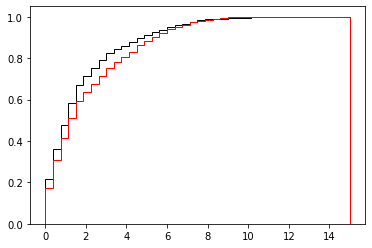

In [336]:
# distributions of values over the first second
plt.hist([stimulation_array[:, BEFORE_STIM_FRAMES:45], control_array[:, 27:45]], bins=40, color=['r', 'k'],
         normed=True, cumulative=True, histtype='step')
plt.show()

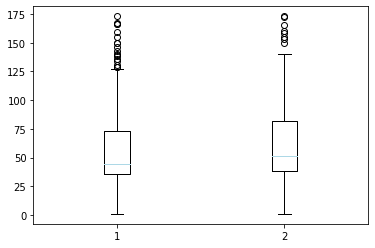

In [337]:
# distributions of latencies

plt.boxplot([stim_arr_movini[stim_arr_movini < 199], control_arr_movini[control_arr_movini < 199]])
plt.show()

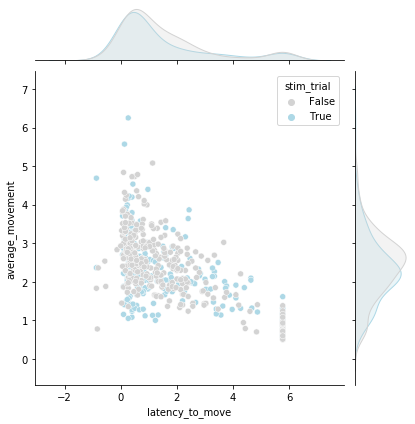

In [338]:
# plot some stats
st_plot = sns.jointplot(data=st_df[mov_mask], x="latency_to_move", y="average_movement", hue="stim_trial")

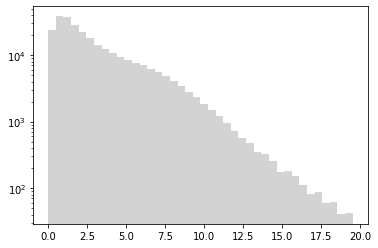

In [339]:
hmask = fdf.speed < 20
plt.hist(fdf.speed[hmask], bins=40)
plt.yscale('log')
plt.show()

## RTPP

In [60]:
def calculate_if_inside(df, bounds):
    xs = df['centroid[0]']
    ys = df['centroid[1]']
    c_a = (xs >= bounds[0]) + 0
    c_b = (xs <= bounds[2]) + 0
    c_c = (ys >= bounds[1]) + 0
    c_d = (ys <= bounds[3]) + 0
    
    return (c_a * c_b * c_c * c_d) == 1


In [62]:
# raw_data_dir = '/mnt/c/Users/herny/Desktop/SWC/Data/Behavioural_Data/rtpp/DA_stimulation_rtpp/raw_data'
# raw_data_dir = '/home/hernandom/data/Behavioural_Data/rtpp/DA_stimulation_rtpp/raw_data'
# raw_data_dir = '/home/hernandom/data/Behavioural_Data/rtpp/DA_stimulation_rtpp/NAc/raw_data'
raw_data_dir = '/home/hernandom/data/Behavioural_Data/rtpp/DA_stimulation_rtpp/raw_data'

# create output dir
out_dir = os.path.join(os.path.dirname(raw_data_dir), 'processed_data/')
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
# find files with the rois info
files = glob.glob(raw_data_dir + '/*_rects.csv')

# read and process files
dfs = []
for file in files:
    print('Working with {}'.format(os.path.basename(file)))
    # find the data file associated to it
    name_pieces = os.path.basename(file).split('_')
    data_file = os.path.join(os.path.dirname(file), '_'.join(name_pieces[:-1]) + '.csv')
#     print(data_file)
    # get the animal name
    an_name = name_pieces[1]
    # open and read the data file
    df = pd.read_csv(data_file, header=None)
    colnames = ['centroid[0]', 'centroid[1]', 'orientation', 'axis_major_length',
                'axis_minor_length', 'isInStimROI', 'firstTimeStampBool', 'timestampFrame', 'pp']
    cndict = {}
    for i,name in enumerate(colnames):
        cndict[i] = name
    df.rename(columns=cndict, inplace=True)
    # add the animal name
    df['animal_id'] = an_name
    # drop True values of the firstTimeStampBool
    df.drop(df[df.firstTimeStampBool].index, inplace=True)
    
    # get the boundaries of first and second ROI in the rectangles file
    first_roi_bounds = pd.read_csv(file, header=None).loc[1].values
    second_roi_bounds = pd.read_csv(file, header=None).loc[2].values
    
    # check if the animal is in the first ROI
    df['isInFirstROI'] = calculate_if_inside(df, first_roi_bounds)
    # check if the animal is in the second ROI
    df['isInSecondROI'] = calculate_if_inside(df, second_roi_bounds)
    
    # drop some columns
    df.drop(['orientation', 'axis_major_length', 'axis_minor_length', 'isInStimROI',
             'timestampFrame', 'firstTimeStampBool', 'centroid[0]', 'centroid[1]'], axis=1, inplace=True)
    
    # append
    dfs.append(df)

# combine
fdf = pd.concat(dfs, ignore_index=True)

Working with rtpp_DAopto-03_tStr-Both__2022_05_04_15_38_45_rects.csv
Working with rtpp_DAopto-02_tStr-Both__2022_05_04_14_58_59_rects.csv
Working with rtpp_DAopto-01_tStr-Both__2022_05_04_14_19_18_rects.csv
Working with rtpp_DAopto-07_tStr-Both__2022_05_04_16_58_47_rects.csv
Working with rtpp_DAopto-08_tStr-Both__2022_05_04_16_19_02_rects.csv


In [63]:
fdf

,pp,animal_id,isInFirstROI,isInSecondROI
0,0,DAopto-03,False,True
1,0,DAopto-03,False,True
2,0,DAopto-03,False,True
3,0,DAopto-03,False,True
4,0,DAopto-03,False,True
...,...,...,...,...
173583,2,DAopto-08,False,True
173584,2,DAopto-08,False,True
173585,2,DAopto-08,False,True
173586,2,DAopto-08,False,True


In [64]:
# get the occupancy percentages
opdf = fdf.groupby(['animal_id', 'pp']).mean().reset_index()

In [65]:
opdf

,animal_id,pp,isInFirstROI,isInSecondROI
0,DAopto-01,0,0.647438,0.399809
1,DAopto-01,1,0.556547,0.526371
2,DAopto-01,2,0.643540,0.402191
3,DAopto-02,0,0.427114,0.487652
4,DAopto-02,1,0.482482,0.442929
5,DAopto-02,2,0.690486,0.265493
6,DAopto-03,0,0.464806,0.587429
7,DAopto-03,1,0.416011,0.674222
8,DAopto-03,2,0.296156,0.765614
9,DAopto-07,0,0.439349,0.702433


In [74]:
# calculate the total percentage of time that they spend in stimulation
# and a random occupancy, taken at random from the baseline phase
animals = []
perctime = []
stimtype = []
for animal in opdf.animal_id.unique():
    andf = opdf[opdf.animal_id == animal]
    stim_in_phase_one = andf[andf.pp == 1].isInFirstROI.values
    stim_in_phase_two = andf[andf.pp == 2].isInSecondROI.values
    # append
    animals.append(animal)
    stimtype.append('laser_ON')
    perctime.append(np.mean([stim_in_phase_one, stim_in_phase_two]))
    # append random
    pp_zero_occs = andf[andf.pp == 0][['isInFirstROI', 'isInSecondROI']].values
    animals.append(animal)
    stimtype.append('random_baseline')
    perctime.append(random.choice(pp_zero_occs[0]))
    

stim_df = pd.DataFrame({'animal_id': animals,
                        'stim_type': stimtype,
                        'occupancy': 100 * np.array(perctime)})

In [75]:
stim_df

,animal_id,stim_type,occupancy
0,DAopto-01,laser_ON,47.936888
1,DAopto-01,random_baseline,64.743757
2,DAopto-02,laser_ON,37.398754
3,DAopto-02,random_baseline,42.711370
4,DAopto-03,laser_ON,59.081261
5,DAopto-03,random_baseline,46.480562
6,DAopto-07,laser_ON,58.638294
7,DAopto-07,random_baseline,43.934885
8,DAopto-08,laser_ON,48.984265
9,DAopto-08,random_baseline,48.431373


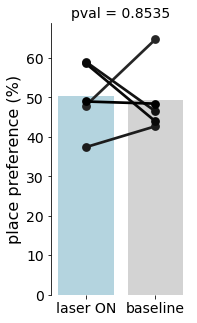

In [76]:
# generate plots
hues = ['lightblue', 'lightgrey']
sns.set_palette(hues)
order_to_plot = ['laser_ON', 'random_baseline']

fig, ax = plt.subplots(1, 1, figsize=[2.5,5])
fig.subplots_adjust(wspace=1)

sns.barplot(data=stim_df, x='stim_type', y='occupancy', ci=False,
            order=order_to_plot, hue_order=order_to_plot, ax=ax, zorder=-40)
sns.pointplot(data=stim_df, x='stim_type', y='occupancy', hue='animal_id',
              color='black', ci=None,
              order=order_to_plot,
              ax=ax)
ax.get_legend().remove()
ax.set_xticklabels(['laser ON', 'baseline'])
ax.set_xlabel('', fontsize=16)
ax.set_ylabel('place preference (%)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(True)
# do stats and add them
tt = stats.ttest_rel(stim_df[stim_df.stim_type == order_to_plot[0]].occupancy.values,
                     stim_df[stim_df.stim_type == order_to_plot[1]].occupancy.values)

ax.text(x=.5, y=ax.get_ylim()[1]*1.02, s='pval = {:.6}'.format(str(tt.pvalue)),
                horizontalalignment='center', fontsize=14)

plt.savefig(out_dir + 'DAstim_when_rtpp.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

In [69]:
# select a session and plot an example of where mouse is located during stimulation
dfs_pp=[]
for file in files:
    print('Working with {}'.format(os.path.basename(file)))
    # find the data file associated to it
    name_pieces = os.path.basename(file).split('_')
    data_file = os.path.join(os.path.dirname(file), '_'.join(name_pieces[:-1]) + '.csv')
    #     print(data_file)
    # get the animal name
    an_name = name_pieces[1]
    # open and read the data file
    df = pd.read_csv(data_file, header=None)
    colnames = ['centroid[0]', 'centroid[1]', 'orientation', 'axis_major_length',
                'axis_minor_length', 'isInStimROI', 'firstTimeStampBool', 'timestampFrame', 'pp']
    cndict = {}
    for i,name in enumerate(colnames):
        cndict[i] = name
    df.rename(columns=cndict, inplace=True)
    # add the animal name
    df['animal_id'] = an_name
    # drop True values of the firstTimeStampBool
    df.drop(df[df.firstTimeStampBool].index, inplace=True)

    # get the boundaries of first and second ROI in the rectangles file
    first_roi_bounds = pd.read_csv(file, header=None).loc[1].values
    second_roi_bounds = pd.read_csv(file, header=None).loc[2].values

    # check if the animal is in the first ROI
    df['isInFirstROI'] = calculate_if_inside(df, first_roi_bounds)
    # check if the animal is in the second ROI
    df['isInSecondROI'] = calculate_if_inside(df, second_roi_bounds)
    dfs_pp.append(df)

# combine
fdf_pp = pd.concat(dfs_pp, ignore_index=True)

Working with rtpp_DAopto-03_tStr-Both__2022_05_04_15_38_45_rects.csv
Working with rtpp_DAopto-02_tStr-Both__2022_05_04_14_58_59_rects.csv
Working with rtpp_DAopto-01_tStr-Both__2022_05_04_14_19_18_rects.csv
Working with rtpp_DAopto-07_tStr-Both__2022_05_04_16_58_47_rects.csv
Working with rtpp_DAopto-08_tStr-Both__2022_05_04_16_19_02_rects.csv


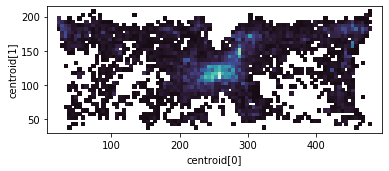

In [70]:
sns.histplot(data=fdf_pp[fdf_pp.pp==2], x='centroid[0]', y='centroid[1]', binwidth=5, pthresh=.1, cmap="mako")
# sns.kdeplot(data=df[df.pp==1], x='centroid[0]', y='centroid[1]', levels=5, color="r", linewidths=1)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

In [ ]:
# stuff that didn't work below

### Analysis of tStr unilateral stimulation

In [66]:
#Subselect dataset
pulledData = AnimalsDF[AnimalsDF.Stimulation != "NoStimulation"]

In [67]:
# Select stimulation in tStr
fib_loc_num = 1
fln_mask = [x['FiberLocation'] == fib_loc_num for x in pulledData.FullGUI]
pulledData = pulledData.iloc[fln_mask]

In [68]:
# TODO: select here dates before the 150-one-port-stimulation change
str_format = '%b%d %H:%M'
limit_date = 'Mar27 23:59'
session_times = [datetime.strptime(x, str_format) for x in pulledData.SessionTime.unique()]
date_mask = [x < datetime.strptime(limit_date, str_format) for x in session_times]
selected_dates = [x.strftime(str_format) for x in np.array(session_times)[date_mask]]
pulledData = pulledData[pulledData.SessionTime.isin(selected_dates)]

In [69]:
# Because we are going to look at the subsequent trial,
# I will 'hack' the dataframe and classify as optostimulated trials,
# the in which the stimulation happened in the trial before.
# That way I can make use of the functions available for analysis

pulledData.OptoStim = np.insert(np.array(pulledData['OptoStim'][:-1]), 0, np.nan)

In [ ]:
# I omit the cell from above and calculate the actual bias of optostim as a control

In [78]:
# Select only those trials where the previous trial is a success
pulledData = pulledData[pulledData.PrevTrialSuccess == 1]

In [10]:
# # Select only those trials where the previous trial is contralateral to the fiber
# # 1 is left poke
# # 2 is right poke

# pulledData['PreviousSide'] = np.nan

# for session_id in pulledData.SessionID.unique():

#     idxs = list(pulledData[pulledData.SessionID == session_id].index)
#     trial_indexes = pulledData[pulledData.SessionID == session_id].TrialIndex

#     for idx in idxs:
#         index_of_trial = pulledData.loc[idx].TrialIndex
#         index_of_previous_trial = index_of_trial - 1
#         idx_prev_list = trial_indexes == index_of_previous_trial
#         if(any(idx_prev_list)):
#             idx_prev = idx_prev_list[idx_prev_list].index.item()
#             side_prev = pulledData.loc[idx_prev].TrialSide
#         else:
#             side_prev = np.nan

#         pulledData.at[idx, 'PreviousSide'] = side_prev

In [11]:
# # Do the selection
# idxs_to_keep = []
# for session_id in pulledData.SessionID.unique():
#     session_data = pulledData[pulledData.SessionID == session_id]
#     stim_side = session_data.Stimulation.unique()[0]
#     if stim_side == 'Right':
#         idxs_to_keep.append(session_data[session_data.PreviousSide == 1].index)
#     if stim_side == 'Left':
#         idxs_to_keep.append(session_data[session_data.PreviousSide == 2].index)

# # flatten
# idxs_to_keep_flat = [item for sublist in idxs_to_keep for item in sublist]

# #select
# pulledData = pulledData.loc[idxs_to_keep_flat]

In [79]:
# Generate random optostimulation choices for every session
n_times = 1000
data = np.empty([len(pd.unique(pulledData['SessionID'])), 3], dtype=object)

for i, session in enumerate(pd.unique(pulledData['SessionID'])):
    # generate the random dataset, and save it to a general dataframe for later use
    session_df = pulledData[pulledData['SessionID'] == session]
    roc = cuf.get_random_optolike_choices(df=session_df, n_times=n_times)
    _, odf = cuf.splitOpto(session_df)
    roc_ds = np.apply_along_axis(cuf.get_choices, 1, roc, trialsDif=odf['Difficulty'])
    avail_diffs = roc_ds[0,0,:]
    rand_choices_ds = roc_ds[:,1,:]
    # fill
    data[i] = [session, avail_diffs, rand_choices_ds]
    
    update_progress(i / len(pd.unique(pulledData['SessionID'])))

random_opto_df = pd.DataFrame(data, columns=['SessionID', 'Difficulties', 'Random_choices'])
update_progress(1)

Progress: [####################] 100.0%


In [80]:
# Calculate the differences between the random choices and the opto ones to measure the bias

random_opto_df['bias'] = None
random_opto_df['bias_mean'] = None
random_opto_df['bias_std'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get data for opto
    opto_df = pulledData[(pulledData['SessionID'] == session) & (pulledData['OptoStim']==1)]
    trialsDif = np.array(opto_df['TrialHighPerc'])
    sideSelected = np.array(opto_df['FirstPoke'])
    difficulty, opto_perf = cuf.get_choices(sideSelected, trialsDif)
    
    # get data for the shuffles
    updown_list = np.empty(n_times)
    for i in range(n_times):
        y_vals = random_opto_df.loc[session_idx].Random_choices[i]
        # calculate difference and normalize
        updown_list[i] = np.sum(y_vals - opto_perf) / len(difficulty)
    
    random_opto_df.at[session_idx, 'bias'] = updown_list
    random_opto_df.at[session_idx, 'bias_mean'] = np.nanmean(updown_list)
    random_opto_df.at[session_idx, 'bias_std'] = np.nanstd(updown_list)
    
    update_progress((sc + 1) / len(pd.unique(random_opto_df['SessionID'])))

Progress: [####################] 100.0%


In [81]:
# add the side in which stimulation happened, and translate the bias to contralateral / ipsilateral
random_opto_df['stimulated_side'] = None
random_opto_df['contralateral_bias'] = None

for session in pd.unique(random_opto_df['SessionID']):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get information
    stim_side = pulledData[pulledData['SessionID'] == session].Stimulation.unique().item()    
    # add info
    random_opto_df.at[session_idx, 'stimulated_side'] = stim_side

    # bias is the normal minus the opto. This means that a positive value is a leftwards bias of the opto trials
    # this is good as a contralateral bias for the trials in which optostimulation occurs in the right side
    # flip the sign of the ones where stimulation happens on the left
    if stim_side == 'Right':
        random_opto_df.at[session_idx, 'contralateral_bias'] = random_opto_df.at[session_idx, 'bias_mean']
    elif stim_side == 'Left':
        random_opto_df.at[session_idx, 'contralateral_bias'] = - random_opto_df.at[session_idx, 'bias_mean']
    elif stim_side == 'Both':
        random_opto_df.at[session_idx, 'contralateral_bias'] = np.nan
    else:
        print('Something wrong')

In [82]:
# Get a column with the mouse name
random_opto_df['AnimalID'] = None
# And the type of mouse
# random_opto_df['Genotype'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()    
    mouse_name = random_opto_df.loc[session_idx].SessionID.split(' ')[0]
    random_opto_df.at[session_idx, 'AnimalID'] = mouse_name
#     random_opto_df.at[session_idx,'Genotype'] = mouse_name.split('-')[0]

In [32]:
# pulledData['PreviousOpto'] = np.nan

# for session_id in pulledData.SessionID.unique():

#     idxs = list(pulledData[pulledData.SessionID == session_id].index)
#     trial_indexes = pulledData[pulledData.SessionID == session_id].TrialIndex

#     for idx in idxs:
#         index_of_trial = pulledData.loc[idx].TrialIndex
#         index_of_previous_trial = index_of_trial - 1
#         idx_prev_list = trial_indexes == index_of_previous_trial
#         if(any(idx_prev_list)):
#             idx_prev = idx_prev_list[idx_prev_list].index.item()
#             opto_prev = pulledData.loc[idx_prev].OptoStim
#         else:
#             opto_prev = np.nan

#         pulledData.at[idx, 'PreviousOpto'] = opto_prev

Progress: [####################] 100.0%


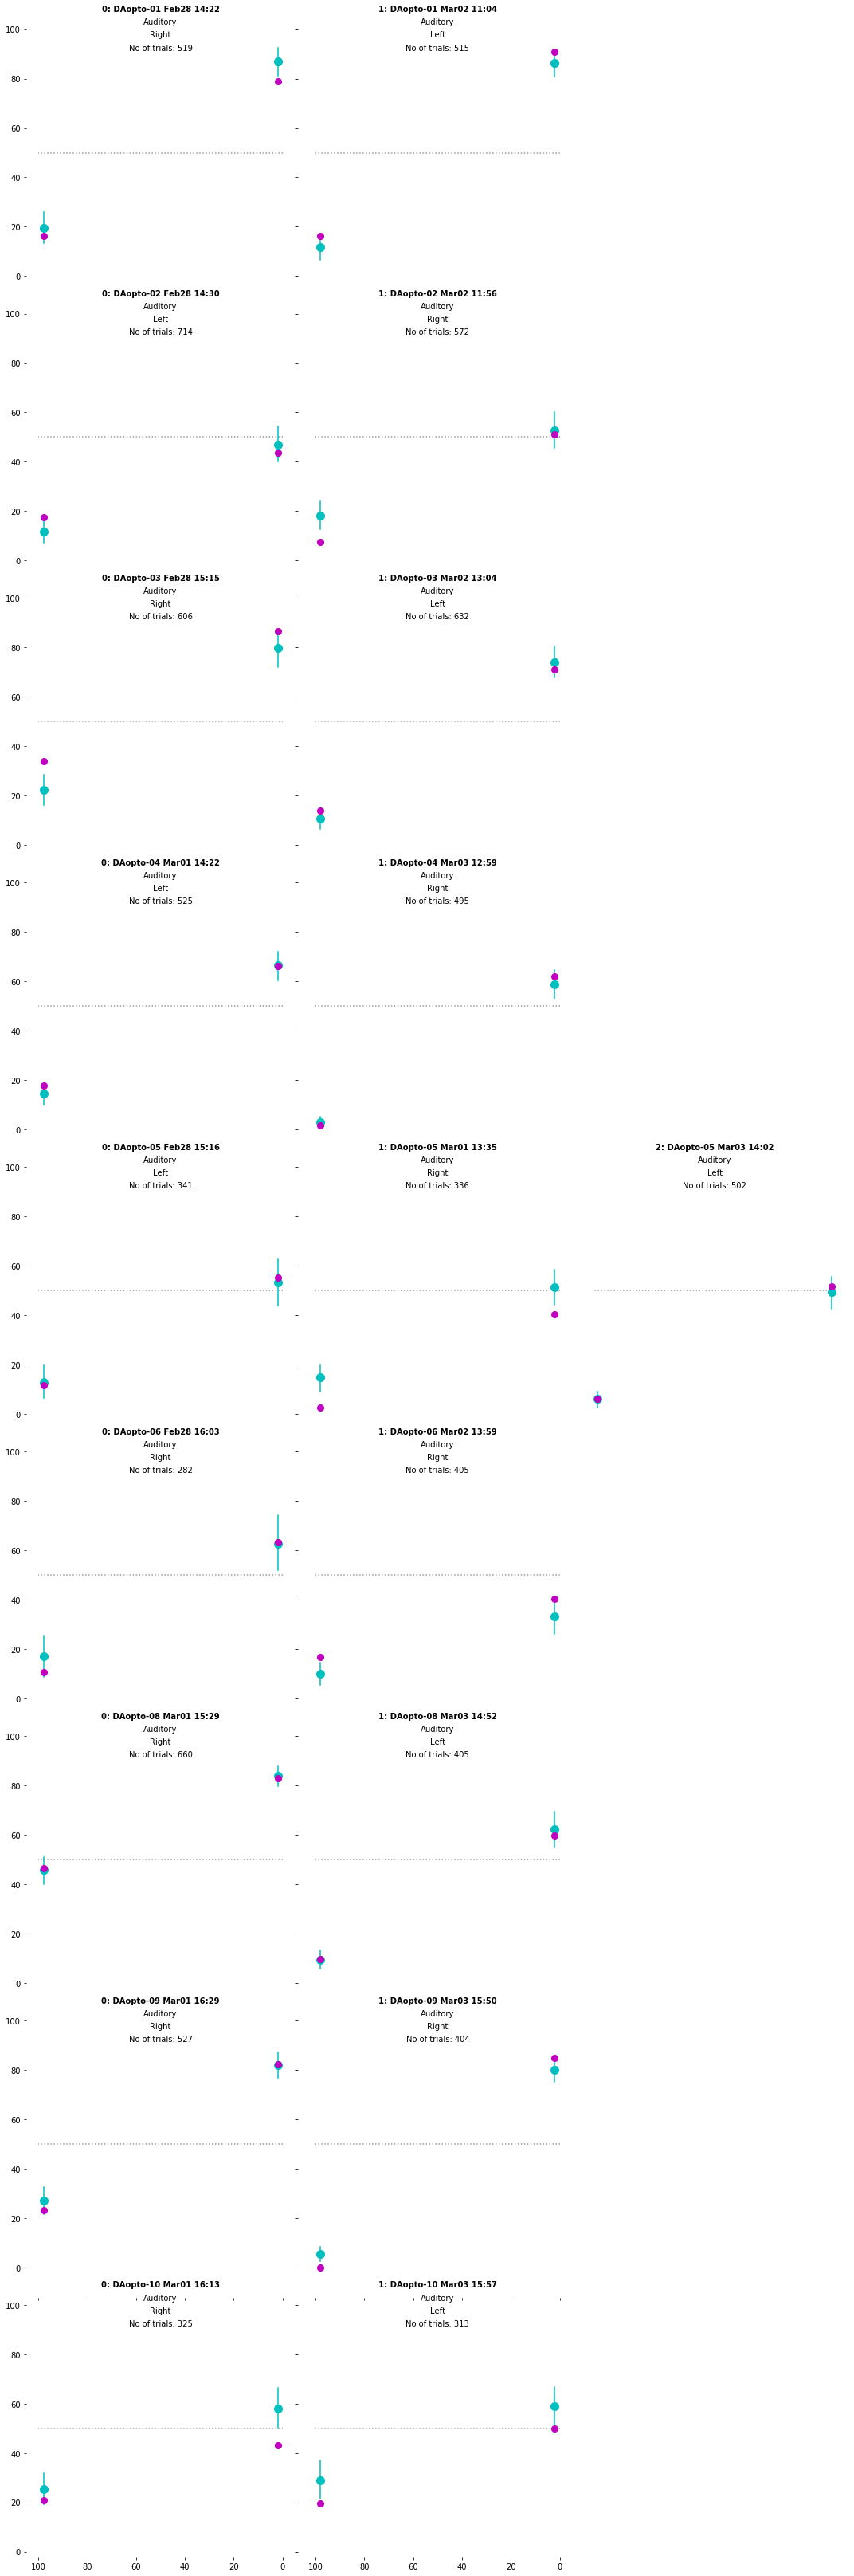

In [74]:
# Plot the data with the error bars for the random sampling

# CondList = [(pulledData['PreviousOpto']==0),
#             (pulledData['PreviousOpto']==1)]
ColorList = ['c', 'm']
LabelList = ['Normal', 'Opto']

n_cols = pulledData.groupby('AnimalID')['SessionID'].nunique().max()
# n_cols = 2

fig, axs = plt.subplots(len(pd.unique(pulledData['AnimalID'])), n_cols,
                        figsize=(5 * n_cols, 5 * len(pd.unique(pulledData['AnimalID']))),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

for ax in axs.ravel(): ax.axis('off')

for an_counter, animal in enumerate(pd.unique(pulledData['AnimalID'])):
    animal_df = pulledData[pulledData['AnimalID'] == animal]
    
    for counter, session in enumerate(pd.unique(animal_df['SessionID'])):
        session_df = pulledData[pulledData['SessionID'] == session]
        
        ax = axs[an_counter, counter]        
        ax.hlines(50, 0, 100, linestyles='dotted', alpha=0.4)

        avail_diffs = random_opto_df[random_opto_df.SessionID == session].Difficulties.item()
        rand_choices_ds = random_opto_df[random_opto_df.SessionID == session].Random_choices.item()
        
        plot_utils.plot_random_optolike_choices(df=session_df,
                                                ax=ax,
                                                fake_dataset_m_and_std=[avail_diffs,
                                                                        np.mean(rand_choices_ds, axis=0),
                                                                        np.std(rand_choices_ds, axis=0)])
        # overlay fits
#         for i, condition in enumerate(CondList):
#             plot_utils.plot_regression(df=animal_df[(animal_df['SessionID'] == session) & condition], ax=ax,
#                                        color=ColorList[i], label=LabelList[i], plot_points=True)
        #axs[counter].set_ylabel('')
        #axs[counter].set_xlabel('')
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
                   
        ax.set_ylim(-2., 102.)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
        ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
                       labelleft='on', labelbottom='on')
        # get rid of the frame
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        plt.tight_layout()
        
        ax.invert_xaxis()
        
#         ax.get_legend().remove()
        ax.text(.5,1.05, str(counter) + ': ' + (session), \
                          horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

        ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.95, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.9, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                          horizontalalignment='center', transform=ax.transAxes)

    update_progress(an_counter / len(pd.unique(pulledData['AnimalID'])))
    
update_progress(1)
plt.savefig(outputDir + output_directory_name + '_difficulty_significance_for_individual_opto_sessions_previous_tStr.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [25]:
random_opto_df

,SessionID,Difficulties,Random_choices,bias,bias_mean,bias_std,stimulated_side,contralateral_bias,AnimalID
0,DAopto-01 Feb28 14:22,"[2.0, 98.0]","[[77.49999999999999, 17.14285714285715], [85.0...","[-2.1428571428571486, -1.249999999999993, 0.53...",3.345,4.2457,Right,3.345,DAopto-01
1,DAopto-01 Mar02 11:04,"[2.0, 98.0]","[[84.61538461538463, 16.666666666666675], [76....","[1.0989010989011065, -7.5091575091575145, 0.09...",0.123718,3.83802,Left,-0.123718,DAopto-01
2,DAopto-02 Feb28 14:30,"[2.0, 98.0]","[[55.10204081632652, 15.999999999999993], [53....","[13.204081632653054, 12.183673469387749, 10.18...",8.39008,4.17921,Left,-8.39008,DAopto-02
3,DAopto-02 Mar02 11:56,"[2.0, 98.0]","[[44.44444444444444, 16.666666666666675], [37....","[-4.126984126984121, -7.460317460317453, -0.87...",-0.151587,4.72379,Right,-0.151587,DAopto-02
4,DAopto-03 Feb28 15:15,"[2.0, 98.0]","[[85.71428571428572, 26.190476190476186], [85....","[6.428571428571431, 2.857142857142861, 4.28571...",3.3869,4.76344,Right,3.3869,DAopto-03
5,DAopto-03 Mar02 13:04,"[2.0, 98.0]","[[81.63265306122449, 18.518518518518512], [69....","[10.657596371882082, 2.683295540438403, 3.9871...",3.414,3.86876,Left,-3.414,DAopto-03
6,DAopto-04 Mar01 14:22,"[2.0, 98.0]","[[57.35294117647059, 17.85714285714286], [80.8...","[-0.5777310924369825, 7.615546218487393, 0.997...",3.52841,3.66828,Left,-3.52841,DAopto-04
7,DAopto-04 Mar03 12:59,"[2.0, 98.0]","[[61.42857142857143, 5.35714285714286], [60.00...","[7.678571428571434, 7.857142857142861, 4.28571...",7.25804,3.03962,Right,7.25804,DAopto-04
8,DAopto-05 Feb28 15:16,"[2.0, 98.0]","[[65.38461538461537, 10.71428571428572], [57.6...","[4.120879120879116, 0.27472527472527286, 3.846...",-1.17555,5.86404,Left,1.17555,DAopto-05
9,DAopto-05 Mar01 13:35,"[2.0, 98.0]","[[60.46511627906976, 12.195121951219523], [51....","[10.521837776517293, 9.52921157118547, 13.0743...",6.17501,4.66195,Right,6.17501,DAopto-05


In [76]:
random_opto_df

,SessionID,Difficulties,Random_choices,bias,bias_mean,bias_std,stimulated_side,contralateral_bias,AnimalID
0,DAopto-01 Feb28 14:22,"[2.0, 98.0]","[[89.4736842105263, 21.62162162162162], [84.21...","[7.9658605974395424, -0.0711237553342805, -0.0...",5.63094,4.21385,Right,5.63094,DAopto-01
1,DAopto-01 Mar02 11:04,"[2.0, 98.0]","[[93.18181818181819, 5.405405405405395], [88.6...","[-4.269041769041773, -3.8390663390663384, -2.4...",-4.68206,3.77861,Left,4.68206,DAopto-01
2,DAopto-02 Feb28 14:30,"[2.0, 98.0]","[[39.58333333333333, 9.80392156862746], [50.0,...","[-6.004901960784314, 0.1838235294117636, 1.164...",-1.14988,4.18614,Left,1.14988,DAopto-02
3,DAopto-02 Mar02 11:56,"[2.0, 98.0]","[[38.29787234042554, 10.000000000000009], [57....","[-5.132978723404246, 9.441489361702128, 9.2553...",6.32886,4.59608,Right,6.32886,DAopto-02
4,DAopto-03 Feb28 15:15,"[2.0, 98.0]","[[70.0, 23.404255319148938], [76.6666666666666...","[-13.652482269503551, -12.446808510638311, -10...",-9.32592,4.87454,Right,-9.32592,DAopto-03
5,DAopto-03 Mar02 13:04,"[2.0, 98.0]","[[82.22222222222221, 17.24137931034482], [71.1...","[7.279693486590032, -1.7241379310344866, -0.49...",-0.025977,3.78443,Left,0.025977,DAopto-03
6,DAopto-04 Mar01 14:22,"[2.0, 98.0]","[[69.35483870967742, 11.290322580645151], [67....","[-1.6129032258064635, -1.7763568394002505e-15,...",-1.57258,3.65079,Left,1.57258,DAopto-04
7,DAopto-04 Mar03 12:59,"[2.0, 98.0]","[[50.0, 3.3898305084745672], [56.0606060606060...","[-5.213148433487413, -3.8777606574216694, 0.08...",-1.1,3.15012,Right,-1.1,DAopto-04
8,DAopto-05 Feb28 15:16,"[2.0, 98.0]","[[72.41379310344827, 15.384615384615374], [44....","[10.543766578249329, -3.2493368700265286, -0.1...",-0.0547082,5.66025,Left,0.0547082,DAopto-05
9,DAopto-05 Mar01 13:35,"[2.0, 98.0]","[[51.06382978723405, 21.62162162162162], [57.4...","[14.778608395629677, 15.267395054629098, 10.72...",11.4172,4.48357,Right,11.4172,DAopto-05


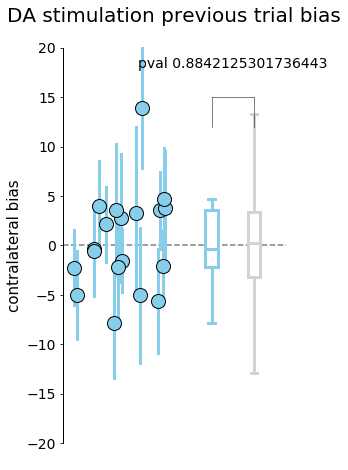

In [83]:
# Pretty version
mice_to_remove = []
animals_list = set(pd.unique(random_opto_df.AnimalID)) - set(mice_to_remove)
jitter = 0.3
alpha = 1
spread = jitter * 1.6
# stim_types = ['Left', 'Right']
mice_cohorts = ['DAopto'] 
colors = 'skyblue'
# labels_for_legend = ['D1-Arch', 'D2-Arch']

fig, ax = plt.subplots(1, 1, figsize = (4, 8), sharey=True)

ax.axhline(0, color='grey', linestyle='--')
ax.set_title('DA stimulation previous trial bias', fontsize=20)
ax.set_xticks([])
ax.set_xlim([-jitter*1.2, jitter*3])
# get rid of the frame
for spine in ax.spines.values():
    spine.set_visible(False)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 

xmin, _ = ax.get_xaxis().get_view_interval()
ax.plot((xmin, xmin), (-20, 20), color='black', linewidth=1) 

ax.set_ylabel('contralateral bias', fontsize=15)

mean_vals = []
x_vals = []
for animal in animals_list:
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    for session in pd.unique(animal_rdf.SessionID):
        session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
        st_t_idx = 0
        sh_d = animal_rdf.loc[session_idx].contralateral_bias
        sh_std = animal_rdf.loc[session_idx].bias_std
        imp_jit = random.uniform(-jitter, jitter)
        x_pos = st_t_idx + imp_jit

        #std
        ax.plot([x_pos, x_pos], [sh_d-sh_std, sh_d+sh_std],
                color=colors, linewidth=3, alpha=alpha)

        #append to list
        mean_vals.append(sh_d)
        x_vals.append(x_pos)
for i in range(len(mean_vals)):
    #mean
    ax.plot(x_vals[i], mean_vals[i], 'o', ms=14, color='k',
            markerfacecolor=colors)


# plot boxplot, and random distribution, and pvalue
xm = np.mean(mean_vals)
xstd = np.std(mean_vals)
bp = ax.boxplot(mean_vals, positions=[spread], widths=0.07, 
             patch_artist=True, showfliers=False)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color=colors, linewidth=3)
for patch in bp['boxes']:
    patch.set(facecolor='white')
# random expectation. Mean at 0 by definition. Use the bias_std to sample from
# do one instance only
random_means = []
for idx in random_opto_df.index.values:
    # get x number of a random bias
    sess_std = random_opto_df.loc[idx].bias_std
    random_means.append(np.random.normal(loc=0.0, scale=sess_std, size=100))
random_means_flat_list = [item for sublist in random_means for item in sublist]
xm = np.mean(random_means_flat_list)
xstd = np.std(random_means_flat_list)
spr_adj = 1.5

bp = ax.boxplot(random_means_flat_list, positions=[spread*spr_adj], widths=0.07, 
             patch_artist=True, showfliers=False)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color='lightgray', linewidth=3)
for patch in bp['boxes']:
    patch.set(facecolor='white')

pval = stats.kruskal(mean_vals, random_means_flat_list).pvalue

# add pvalues info
hlocs = 15
hadj = 1.2

pvaltext = str(pval)

ax.text(x=spread*(1 + spr_adj)/2, y=hlocs*hadj, s='pval {}'.format(str(pvaltext)),
        horizontalalignment='center', fontsize=14)
ax.plot([spread, spread*spr_adj], [hlocs, hlocs], color='k', linewidth=.5)
ax.plot([spread, spread], [hlocs, hlocs*.8], color='k', linewidth=.5)
ax.plot([spread*spr_adj, spread*spr_adj], [hlocs, hlocs*.8], color='k', linewidth=.5)
ax.set_xticks([])
                
plt.savefig(outputDir + output_directory_name + '_DAstim-previous-trial_contralateral_pretty.pdf',
            transparent=True, bbox_inches='tight')

plt.show(fig)

In [26]:
opto_df_sel = random_opto_df.copy()

In [27]:
# We cannot repeat points. If several sessions exist for one mouse on the same conditions of hemisphere
# and stimulated side, combine them (average results), or select one of them based on performance or time
# when it was done

# Find indexes of repeated cases
same_columns = ['AnimalID', 'stimulated_side']
equal_indexes = []

for index in opto_df_sel.index:
    data = opto_df_sel.loc[index][same_columns].values
    i_list = []
    for i in opto_df_sel.index:
        if np.array_equal(data, opto_df_sel.loc[i][same_columns].values):
            i_list.append(i)
    if len(i_list) > 1:
        if i_list not in equal_indexes:
            equal_indexes.append(i_list)

equal_indexes

[[8, 10], [11, 12], [15, 16]]

In [29]:
opto_df_sel.columns

Index(['SessionID', 'Difficulties', 'Random_choices', 'bias', 'bias_mean',
       'bias_std', 'stimulated_side', 'contralateral_bias', 'AnimalID'],
      dtype='object')

In [30]:
# Combine those cases
for case in equal_indexes:   
    sub_df = opto_df_sel.loc[case].copy()
    # create new instance to add to the dataframe, initiating it in the first index of the set
    new_element = sub_df.iloc[0].copy()
    # change relevant values
    new_element.SessionID = 'merge'
#     new_element.Ntrials = np.mean(sub_df.Ntrials.values)
#     new_element.Protocol = 'merge'
    new_element.Difficulties = np.nan
    new_element.Random_choices = np.nan
    new_element.bias = np.concatenate(sub_df.bias.values)
    new_element.bias_mean = np.mean(new_element.bias)
    new_element.bias_std = np.std(new_element.bias)
    new_element.contralateral_bias = new_element.bias_mean
    if new_element.stimulated_side == 'Left':
        new_element.contralateral_bias = - new_element.contralateral_bias
    # remove old indexes
    opto_df_sel.drop(case, inplace=True)
    # add new row
    opto_df_sel = opto_df_sel.append(new_element)
opto_df_sel.sort_index(inplace=True)

In [32]:
opto_df_sel['FiberArea'] = 'tStr'

In [ ]:
# remove Animals, TODO!!!!
# idx_to_remove = opto_df_sel[np.logical_and(opto_df_sel.AnimalID=='DAopto-03',
#                            opto_df_sel.FiberArea=='NAc')].index

# opto_df_sel.drop(idx_to_remove, inplace=True)

### nAc stimulation

In [57]:
#Subselect dataset
pulledData = AnimalsDF[AnimalsDF.Stimulation != "NoStimulation"]

In [58]:
#Subselect dataset psychometric
pulledData = pulledData[pulledData.Protocol == "Aud_Psycho"]

In [59]:
# Select stimulation in tStr
fib_loc_num = 2
fln_mask = [x['FiberLocation'] == fib_loc_num for x in pulledData.FullGUI]
pulledData = pulledData.iloc[fln_mask]

In [60]:
# Because we are going to look at the subsequent trial,
# I will 'hack' the dataframe and classify as optostimulated trials,
# the in which the stimulation happened in the trial before.
# That way I can make use of the functions available for analysis

pulledData.OptoStim = np.insert(np.array(pulledData['OptoStim'][:-1]), 0, np.nan)

In [61]:
# MAYBE CHANGE THIS FOR NAc or consider analysing wrong trials as well

# Select only those trials where the previous trial is a success
pulledData = pulledData[pulledData.PrevTrialSuccess == 1]

In [62]:
# Find where the previous side happened
# 1 is left poke
# 2 is right poke

pulledData['PreviousSide'] = np.nan

for session_id in pulledData.SessionID.unique():

    idxs = list(pulledData[pulledData.SessionID == session_id].index)
    trial_indexes = pulledData[pulledData.SessionID == session_id].TrialIndex

    for idx in idxs:
        index_of_trial = pulledData.loc[idx].TrialIndex
        index_of_previous_trial = index_of_trial - 1
        idx_prev_list = trial_indexes == index_of_previous_trial
        if(any(idx_prev_list)):
            idx_prev = idx_prev_list[idx_prev_list].index.item()
            side_prev = pulledData.loc[idx_prev].TrialSide
        else:
            side_prev = np.nan

        pulledData.at[idx, 'PreviousSide'] = side_prev

In [63]:
# Select only one side. This is faster and uglier
selected_prev_side = 1
pulledData = pulledData[pulledData.PreviousSide == selected_prev_side]

In [64]:
# Generate random optostimulation choices for every session
n_times = 1000
data = np.empty([len(pd.unique(pulledData['SessionID'])), 3], dtype=object)

for i, session in enumerate(pd.unique(pulledData['SessionID'])):
    # generate the random dataset, and save it to a general dataframe for later use
    session_df = pulledData[pulledData['SessionID'] == session]
    roc = cuf.get_random_optolike_choices(df=session_df, n_times=n_times)
    _, odf = cuf.splitOpto(session_df)
    roc_ds = np.apply_along_axis(cuf.get_choices, 1, roc, trialsDif=odf['Difficulty'])
    avail_diffs = roc_ds[0,0,:]
    rand_choices_ds = roc_ds[:,1,:]
    # fill
    data[i] = [session, avail_diffs, rand_choices_ds]
    
    update_progress(i / len(pd.unique(pulledData['SessionID'])))

random_opto_df = pd.DataFrame(data, columns=['SessionID', 'Difficulties', 'Random_choices'])
update_progress(1)

Progress: [####################] 100.0%


In [65]:
# Calculate the differences between the random choices and the opto ones to measure the bias

random_opto_df['bias'] = None
random_opto_df['bias_mean'] = None
random_opto_df['bias_std'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get data for opto
    opto_df = pulledData[(pulledData['SessionID'] == session) & (pulledData['OptoStim']==1)]
    trialsDif = np.array(opto_df['TrialHighPerc'])
    sideSelected = np.array(opto_df['FirstPoke'])
    difficulty, opto_perf = cuf.get_choices(sideSelected, trialsDif)
    
    # get data for the shuffles
    updown_list = np.empty(n_times)
    for i in range(n_times):
        y_vals = random_opto_df.loc[session_idx].Random_choices[i]
        # calculate difference and normalize
        updown_list[i] = np.sum(y_vals - opto_perf) / len(difficulty)
    
    random_opto_df.at[session_idx, 'bias'] = updown_list
    random_opto_df.at[session_idx, 'bias_mean'] = np.nanmean(updown_list)
    random_opto_df.at[session_idx, 'bias_std'] = np.nanstd(updown_list)
    
    update_progress((sc + 1) / len(pd.unique(random_opto_df['SessionID'])))

Progress: [####################] 100.0%


In [66]:
# add the side in which stimulation happened, and translate the bias to contralateral / ipsilateral
random_opto_df['stimulated_side'] = None
random_opto_df['contralateral_bias'] = None

for session in pd.unique(random_opto_df['SessionID']):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get information
    stim_side = pulledData[pulledData['SessionID'] == session].Stimulation.unique().item()    
    # add info
    random_opto_df.at[session_idx, 'stimulated_side'] = stim_side

    # bias is the normal minus the opto. This means that a positive value is a leftwards bias of the opto trials
    # this is good as a contralateral bias for the trials in which optostimulation occurs in the right side
    # flip the sign of the ones where stimulation happens on the left
    if stim_side == 'Right':
        random_opto_df.at[session_idx, 'contralateral_bias'] = random_opto_df.at[session_idx, 'bias_mean']
    elif stim_side == 'Left':
        random_opto_df.at[session_idx, 'contralateral_bias'] = - random_opto_df.at[session_idx, 'bias_mean']
    elif stim_side == 'Both':
        random_opto_df.at[session_idx, 'contralateral_bias'] = np.nan
    else:
        print('Something wrong')

In [67]:
# Get a column with the mouse name
random_opto_df['AnimalID'] = None
# And the type of mouse
# random_opto_df['Genotype'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()    
    mouse_name = random_opto_df.loc[session_idx].SessionID.split(' ')[0]
    random_opto_df.at[session_idx, 'AnimalID'] = mouse_name
#     random_opto_df.at[session_idx,'Genotype'] = mouse_name.split('-')[0]

In [68]:
pulledData['PreviousOpto'] = np.nan

for session_id in pulledData.SessionID.unique():

    idxs = list(pulledData[pulledData.SessionID == session_id].index)
    trial_indexes = pulledData[pulledData.SessionID == session_id].TrialIndex

    for idx in idxs:
        index_of_trial = pulledData.loc[idx].TrialIndex
        index_of_previous_trial = index_of_trial - 1
        idx_prev_list = trial_indexes == index_of_previous_trial
        if(any(idx_prev_list)):
            idx_prev = idx_prev_list[idx_prev_list].index.item()
            opto_prev = pulledData.loc[idx_prev].OptoStim
        else:
            opto_prev = np.nan

        pulledData.at[idx, 'PreviousOpto'] = opto_prev

Progress: [####################] 100.0%


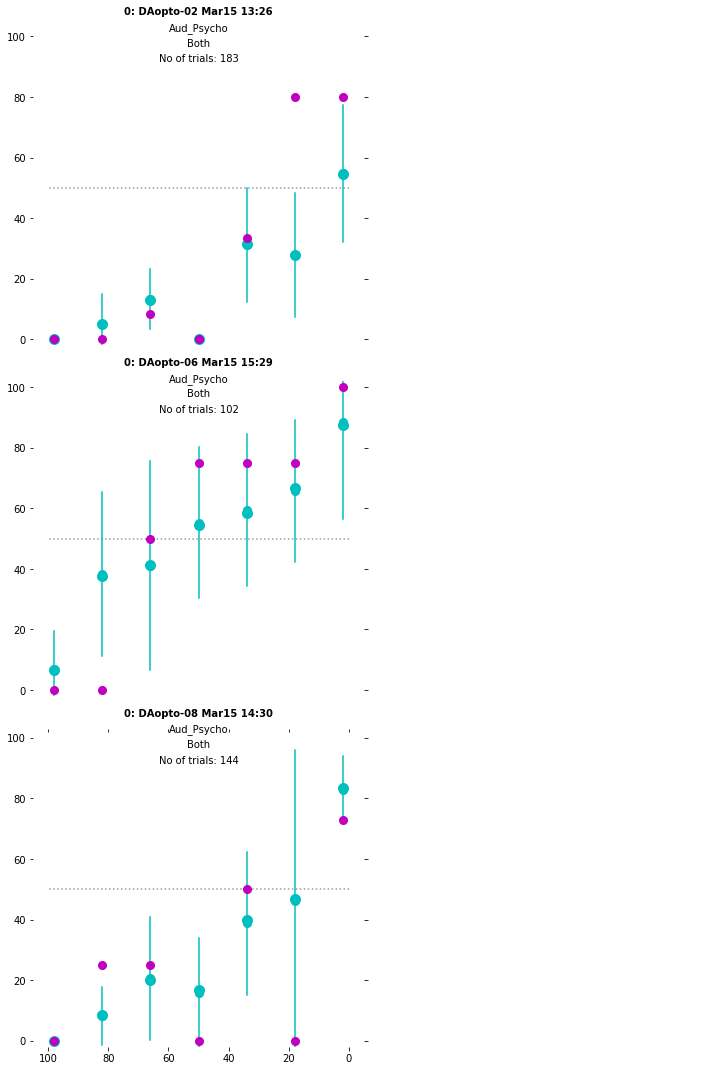

In [69]:
# Plot the data with the error bars for the random sampling

# CondList = [(pulledData['PreviousOpto']==0),
#             (pulledData['PreviousOpto']==1)]
ColorList = ['c', 'm']
LabelList = ['Previous Normal', 'Previous Opto']

# n_cols = pulledData.groupby('AnimalID')['SessionID'].nunique().max()
n_cols = 2

fig, axs = plt.subplots(len(pd.unique(pulledData['AnimalID'])), n_cols,
                        figsize=(5 * n_cols, 5 * len(pd.unique(pulledData['AnimalID']))),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

for ax in axs.ravel(): ax.axis('off')

for an_counter, animal in enumerate(pd.unique(pulledData['AnimalID'])):
    animal_df = pulledData[pulledData['AnimalID'] == animal]
    
    for counter, session in enumerate(pd.unique(animal_df['SessionID'])):
        session_df = pulledData[pulledData['SessionID'] == session]
        
        ax = axs[an_counter, counter]        
        ax.hlines(50, 0, 100, linestyles='dotted', alpha=0.4)

        avail_diffs = random_opto_df[random_opto_df.SessionID == session].Difficulties.item()
        rand_choices_ds = random_opto_df[random_opto_df.SessionID == session].Random_choices.item()
        
        plot_utils.plot_random_optolike_choices(df=session_df,
                                                ax=ax,
                                                fake_dataset_m_and_std=[avail_diffs,
                                                                        np.mean(rand_choices_ds, axis=0),
                                                                        np.std(rand_choices_ds, axis=0)])

        #axs[counter].set_ylabel('')
        #axs[counter].set_xlabel('')
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
                   
        ax.set_ylim(-2., 102.)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
        ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
                       labelleft='on', labelbottom='on')
        # get rid of the frame
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        plt.tight_layout()
        
        ax.invert_xaxis()
        
#         ax.get_legend().remove()
        ax.text(.5,1.05, str(counter) + ': ' + (session), \
                          horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

        ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.95, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.9, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                          horizontalalignment='center', transform=ax.transAxes)

    update_progress(an_counter / len(pd.unique(pulledData['AnimalID'])))
    
update_progress(1)

if selected_prev_side == 1:
    sps_str = 'left'
if selected_prev_side == 2:
    sps_str = 'right'

plt.savefig(outputDir + output_directory_name + \
            '_difficulty_significance_for_individual_opto_sessions_previous_nAc_previous-' + sps_str + '.pdf',
            transparent=True, bbox_inches='tight')

plt.show(fig)